In [1]:
from collections import Counter
import math
import re

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

In [2]:
# Load the questionaire to access options
import json

with open("data/neuroimaging_landscape_survey.json") as q:
    questions = json.load(q)
    

In [3]:
q_name_option_mapping = {}
relevent_qs = questions['template']['steps']['xym8f2fbv6']['template']['widgets']
for q in relevent_qs.keys():
    try:
        q_name_option_mapping[relevent_qs[q]['template']['label']['logic']['value']] = [o['label']['logic']['value'] for o in relevent_qs[q]['template']['options']['staticOptions']]
    except KeyError:
        print(f"Question {q} has no options")
# q_name = questions['template']['steps']['xym8f2fbv6']['template']['widgets']['1Buytrx4WMw5WXF2oZcCcF']['template']['label']['logic']['value']
# q_options = [q['label']['logic']['value'] for q in questions['template']['steps']['xym8f2fbv6']['template']['widgets']['1Buytrx4WMw5WXF2oZcCcF']['template']['options']['staticOptions']]

Question fzk2D7C2Mv9YUg5WjB5Y4D has no options
Question gRUU3v2Bkb3LV8G8nvzSxs has no options
Question ig1Vm19EaCRbzML2969dRH has no options


In [4]:
# Remove HTML tags from the keys
cleaned_q_name_option_mapping = {re.sub(r'<.*?>', '', key): value for key, value in q_name_option_mapping.items()}

In [5]:
# Read the CSV file using pandas
df = pd.read_csv("data/country_continent.csv")

# Convert the DataFrame to a dictionary
country_to_continent = df.set_index('country')['continent'].to_dict()


In [6]:
def preprocess_question(f_survey, question, replacements=None, multichoice=True):
    """Clean the answers from a question in the survey."""
    q_options = cleaned_q_name_option_mapping[question]
    q_survey = f_survey.dropna(subset=[question])

    # before and after may be necessary
    if replacements is not None:
        q_survey.replace(replacements, inplace=True)

    if multichoice:
        q_survey.loc[:, question] = q_survey[question].apply(lambda x: remove_commas_within_phrases(q_options, x))
        q_survey.loc[:, question] = q_survey[question].str.split(',')
        q_survey = q_survey.explode(question)
        if replacements is not None:
            q_survey.replace(replacements, inplace=True)
    
    return q_survey

In [7]:
def remove_commas_within_phrases(phrases, combined_text):
    # Create a function to remove commas within parentheses for each phrase
    def clean_phrase(phrase):
        # Replace commas within parentheses in each phrase
        return re.sub(r'\(.*?\)', lambda m: m.group(0).replace(',', ' '), phrase)

    # Clean each phrase in the list
    cleaned_phrases = [clean_phrase(phrase) for phrase in phrases]

    # Replace the original phrases in the combined text with their cleaned versions
    for original, cleaned in zip(phrases, cleaned_phrases):
        combined_text = combined_text.replace(original, cleaned)

    return combined_text


In [8]:
# Function to extract and clean categories from a string
def extract_and_clean_categories(text):
    # Remove text within parentheses
    text = re.sub(r'\s*\(.*?\)', '', text)
    # Remove brackets and split by ','
    text = text.strip('[]')
    categories = [cat.strip() for cat in text.split(',')]
    return categories

# Function to insert a newline if the label is longer than 20 characters
def insert_newline(label, max_length=20):
    if len(label) > max_length:
        # Find the position of the nearest space after the max_length
        split_pos = label.find(' ', max_length)
        if split_pos != -1:
            return label[:split_pos] + '\n' + label[split_pos+1:]
    return label

def plot_categorical_by_continent(
    survey, question, category_name, exclude_categories=set(),
    top_plot_separation=0.9, bottom_plot_squeeze=0.05, x_label_rotation=55,
    all_categories=None):

    if all_categories is None:
        all_categories = set()
        for row in survey[question].dropna():
            categories = extract_and_clean_categories(row)
            categories = [cat for cat in categories if cat not in exclude_categories]
            all_categories.update(categories)
        all_categories = sorted(all_categories)
    
    
    formatted_category_map = {cat: insert_newline(cat) for cat in all_categories}
    formatted_categories = list(formatted_category_map.values())

    continents = survey['Continent'].unique()

    total_subplots = len(continents)
    rows = (total_subplots + 2) // 3
    fig, axes = plt.subplots(rows + 1, 3, figsize=(16, 4 * (rows + 1)), sharey=True)

    overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)
    
    overall_counter = Counter()
    for row in survey[question].dropna():
        categories = extract_and_clean_categories(row)
        categories = [cat for cat in categories if cat not in exclude_categories]
        overall_counter.update(categories)

    overall_count_df = pd.DataFrame(overall_counter.items(), columns=[category_name, 'Count'])
    overall_count_df[category_name] = overall_count_df[category_name].map(formatted_category_map)
    overall_count_df = overall_count_df.set_index(category_name).reindex(formatted_categories, fill_value=0).reset_index()

    overall_count_df = overall_count_df[overall_count_df['Count'] != 0]

    # Use the colorblind palette
    palette = sns.color_palette("colorblind", len(formatted_categories))

    sns.barplot(hue=category_name, x=category_name, y='Count', data=overall_count_df, palette=palette, ax=overall_ax)
    overall_ax.set_ylabel('Count')
    overall_ax.set_title(f'{category_name}', fontsize=14, fontweight='bold')
    overall_ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    overall_ax.set_xticks(range(len(formatted_categories)))
    overall_ax.set_xticklabels(formatted_categories, rotation=x_label_rotation, fontweight='bold')
    overall_ax.set_xlabel("")
    overall_ax.yaxis.set_tick_params(which='both', length=0)

    legend_handles = [mlines.Line2D([0], [0], color=palette[i], lw=2, label=cat) 
                    for i, cat in enumerate(formatted_categories)]
    overall_ax.legend(handles=legend_handles, title=category_name, loc='upper right', fontsize='small')

    row_index = 1
    for i, continent in enumerate(continents):
        if i % 3 == 0 and i > 0:
            row_index += 1
        ax = axes[row_index, i % 3]

        continent_data = survey[survey['Continent'] == continent]
        counter = Counter()
        for row in continent_data[question].dropna():
            categories = extract_and_clean_categories(row)
            categories = [cat for cat in categories if cat not in exclude_categories]
            counter.update(categories)

        count_df = pd.DataFrame(counter.items(), columns=[category_name, 'Count'])
        count_df[category_name] = count_df[category_name].map(formatted_category_map)
        count_df = count_df.set_index(category_name).reindex(formatted_categories, fill_value=0).reset_index()


        sns.barplot(hue=category_name, x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
        ax.set_ylabel('Count')
        ax.set_title(f'{continent}', fontsize=14, fontweight='bold')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(range(len(formatted_categories)))
        ax.set_xticklabels([])
        ax.set_xlabel("")

    # Adjust space between the overall graph and the continent-specific graphs
    plt.subplots_adjust(hspace=top_plot_separation)  # Larger space between the first and second rows

    # Manually reduce the space between continent-specific graphs
    for ax_row in axes[2:]:  # This targets the rows after the second one
        for ax in ax_row:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0 + bottom_plot_squeeze, box.width, box.height])  # Move up by 0.05

    plt.savefig(f"{category_name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()


In [9]:
# some massaging of inputs between surveys

replace_columns = {
    'Which country do you currently work in?': 'Which country do you reside?',
    'What is your academic/career stage?': 'What is your primary role?',
}

replace_values = {
    "0-8 years Early (e.g. grad student, postdoc, intern)": "Graduate Student",
    "9-15 years Mid (e.g. manager, assistant professor, associate professor)": "Faculty",  
}

In [10]:
globe_survey = pd.read_csv('data/2024_09_12_survey.csv')
idor_survey = pd.read_csv('data/2024_09_12_idor1_survey.csv')

idor_survey.replace(replace_values, inplace=True)
idor_survey.rename(columns=replace_columns, inplace=True)



survey = pd.concat([globe_survey, idor_survey])


survey['Which country do you reside?'].replace({"Gambia, The": "Gambia"}, inplace=True)
survey['What is your primary role?'].replace({"Medical Radiographer ": "Technician", "Founder": "Other"}, inplace=True)
survey.replace(replace_values, inplace=True)

Continent counts:
       Continent  Count
0  North America     33
1         Africa     24
2         Europe     16
3  South America      7
4           Asia      4
5        Oceania      3


/tmp/ipykernel_1736249/2234043718.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


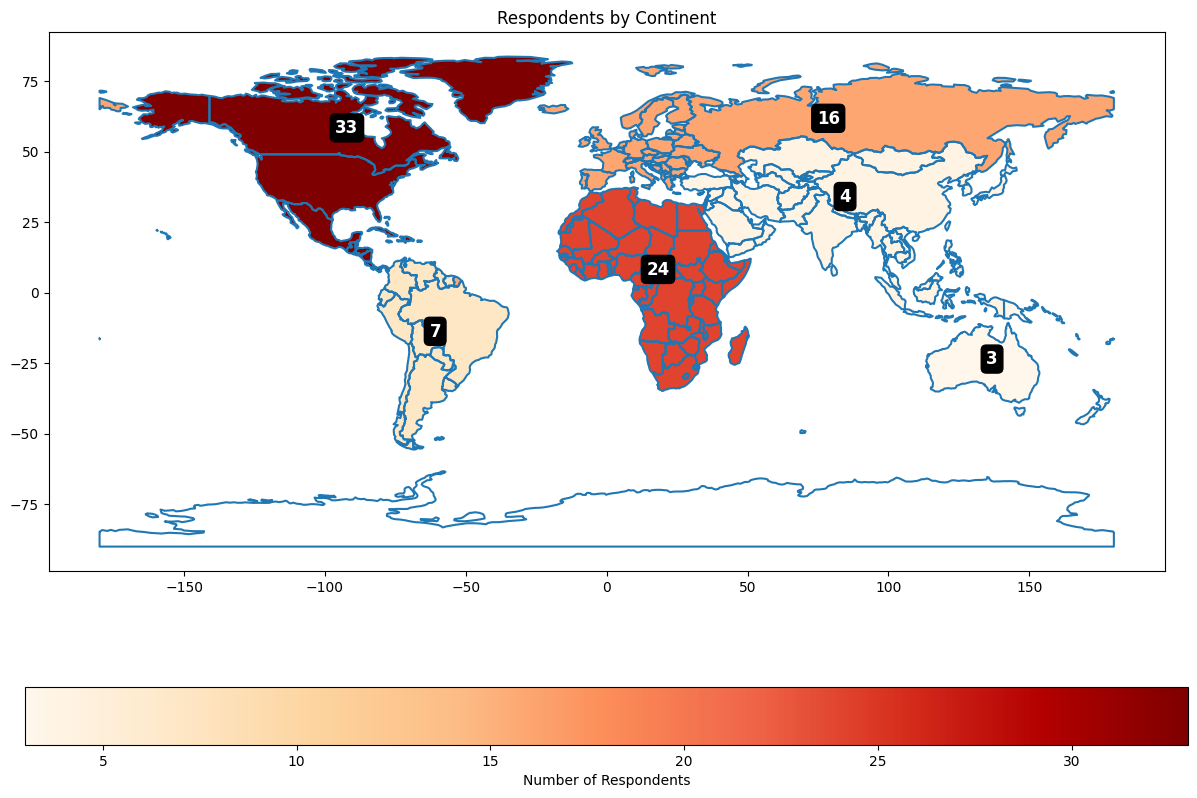

In [11]:
# Question 1: Which country do you reside?

survey['Continent'] = survey['Which country do you reside?'].map(country_to_continent)

# Count the number of respondents per continent
continent_counts = survey['Continent'].value_counts().reset_index()
continent_counts.columns = ['Continent', 'Count']

# Display the continent counts
print("Continent counts:")
print(continent_counts)

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Aggregate the counts per continent
continent_counts_dict = continent_counts.set_index('Continent').to_dict()['Count']

# Assign counts to the continents in the world map
world['Count'] = world['continent'].map(continent_counts_dict)

# Plot the map with a heatmap effect
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='Count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Number of Respondents", 'orientation': "horizontal"})

# Add labels for the counts
for continent, count in continent_counts_dict.items():
    # Calculate the centroid of the continent for the label position
    continent_geom = world[world['continent'] == continent].geometry.unary_union
    centroid = continent_geom.centroid
    plt.text(x=centroid.x, y=centroid.y, s=f"{count}", horizontalalignment='center', fontsize=12, fontweight='bold',
             color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))


plt.title('Respondents by Continent')
plt.savefig("location.png", bbox_inches='tight')
plt.show()

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


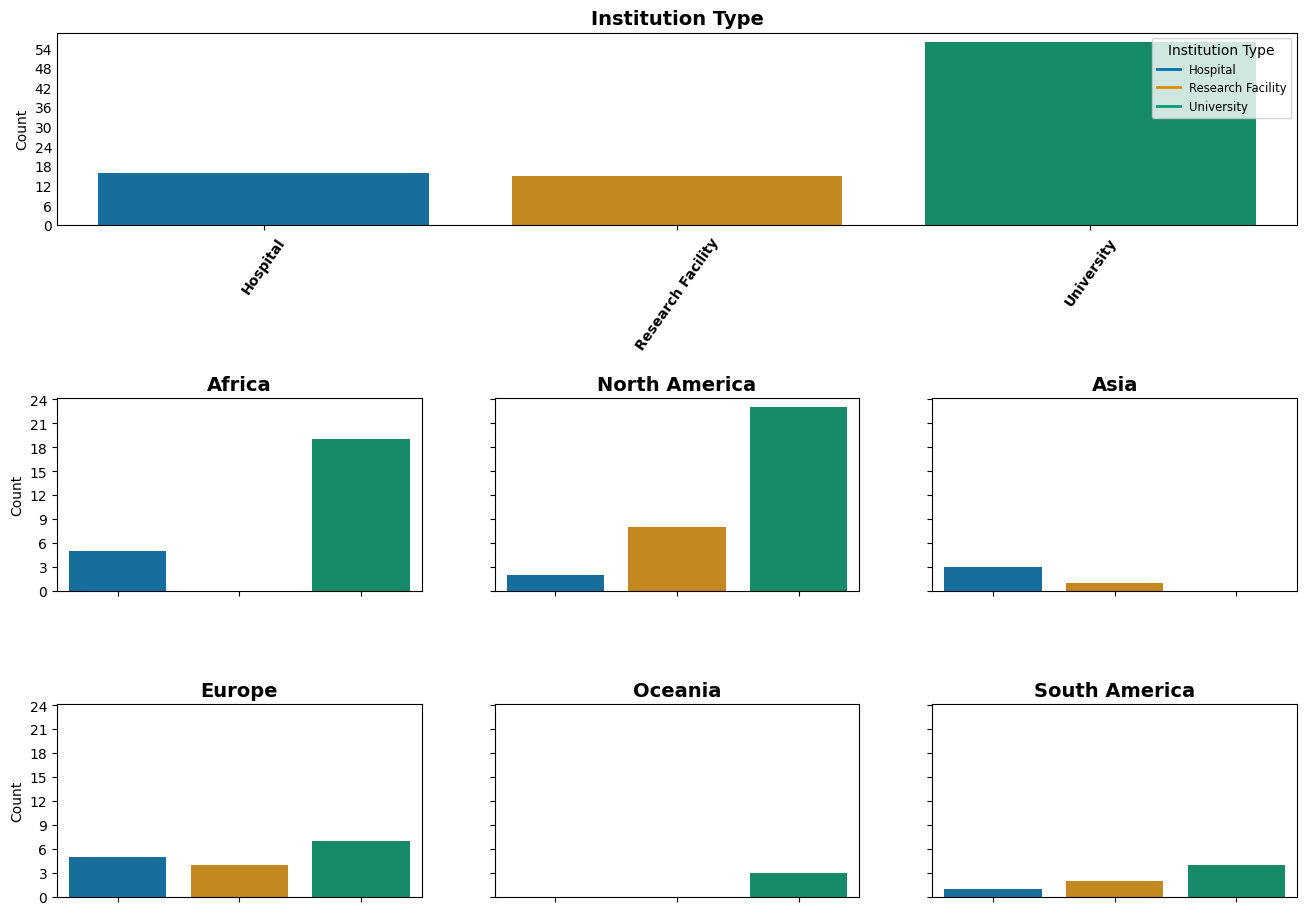

In [12]:
# Question 2: What type of institution are you employed
q2 = "What type of institution are you employed?"
q2_replacements = {"UNIVERSITY HOSPITAL": "University", "Startups": "Research Facility"}
q2_survey = preprocess_question(survey, q2, q2_replacements, multichoice=False)

plot_categorical_by_continent(
    q2_survey,
    "What type of institution are you employed?",
    "Institution Type",
)

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


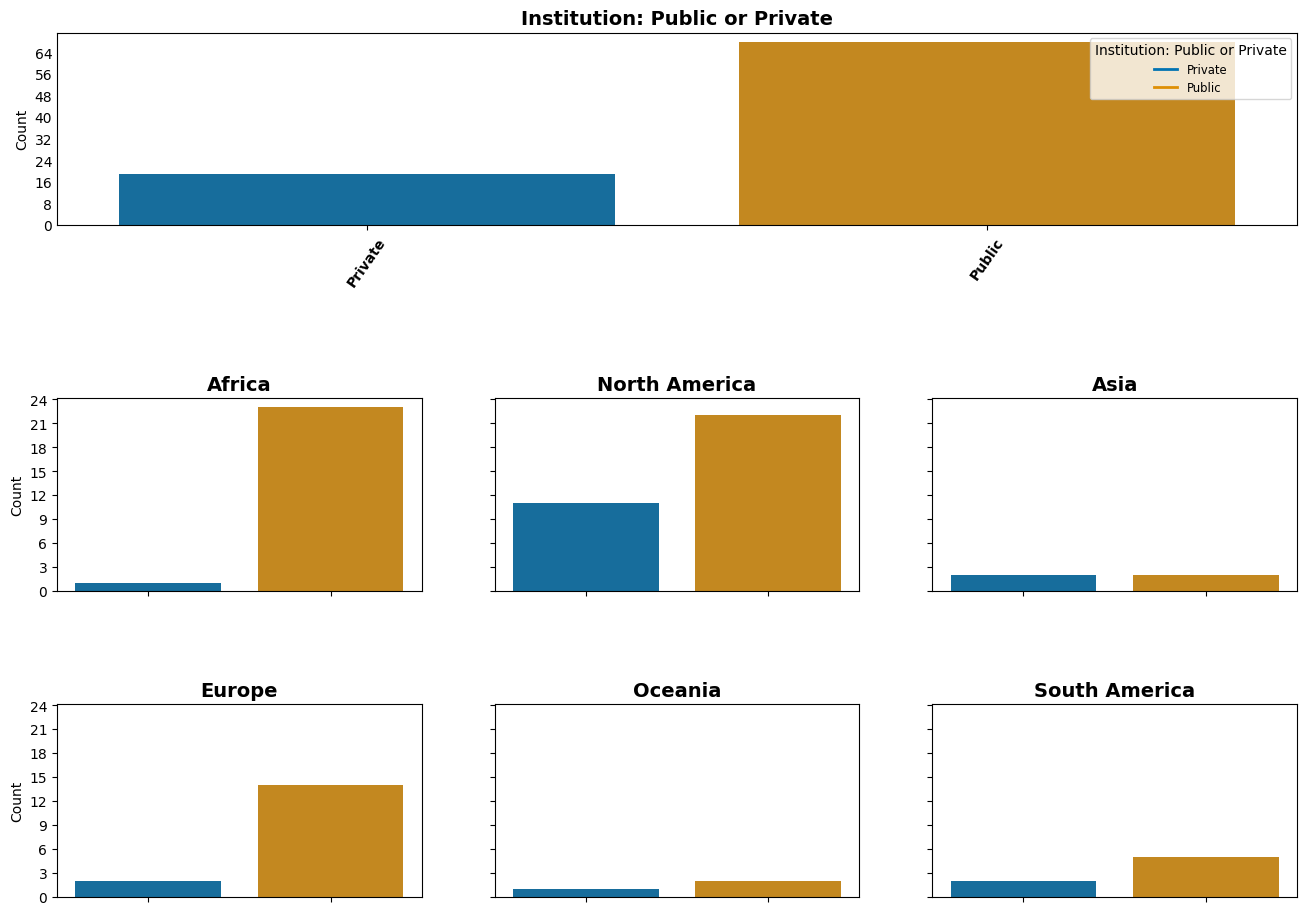

In [13]:
# Question 3: Is the institution public or private?

q3 = "Is the institution public or private?"
q3_replacements = {"both public and private ": "Public"}
q3_survey = preprocess_question(survey, q3, q3_replacements, multichoice=False)

plot_categorical_by_continent(
    q3_survey,
    "Is the institution public or private?",
    "Institution: Public or Private",
)

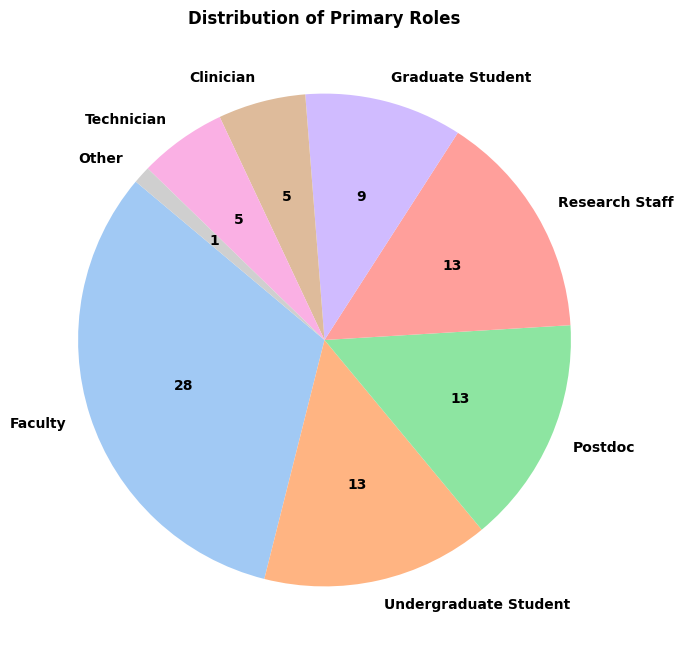

In [14]:
# Question 4: What is your primary role?
q4 = "What is your primary role?"
q4_replacements = {"Medical Radiographer ": "Technician", "Founder": "Other"}
survey[q4].replace(q4_replacements, inplace=True)
role_counts = survey[q4].value_counts()

# Define a function to format the labels with the raw count
def func(pct, allvalues):
    absolute = pct / 100. * sum(allvalues)
    if absolute < 1:
        absolute = math.ceil(absolute)  # Ensure no values round down to 0
    else:
        absolute = round(absolute)
    return f'{absolute}'

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(role_counts, labels=role_counts.index, textprops={'fontweight': 'bold'}, autopct=lambda pct: func(pct, role_counts), startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Primary Roles', fontweight="bold")
plt.savefig("roles.png", bbox_inches='tight')
plt.show()

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


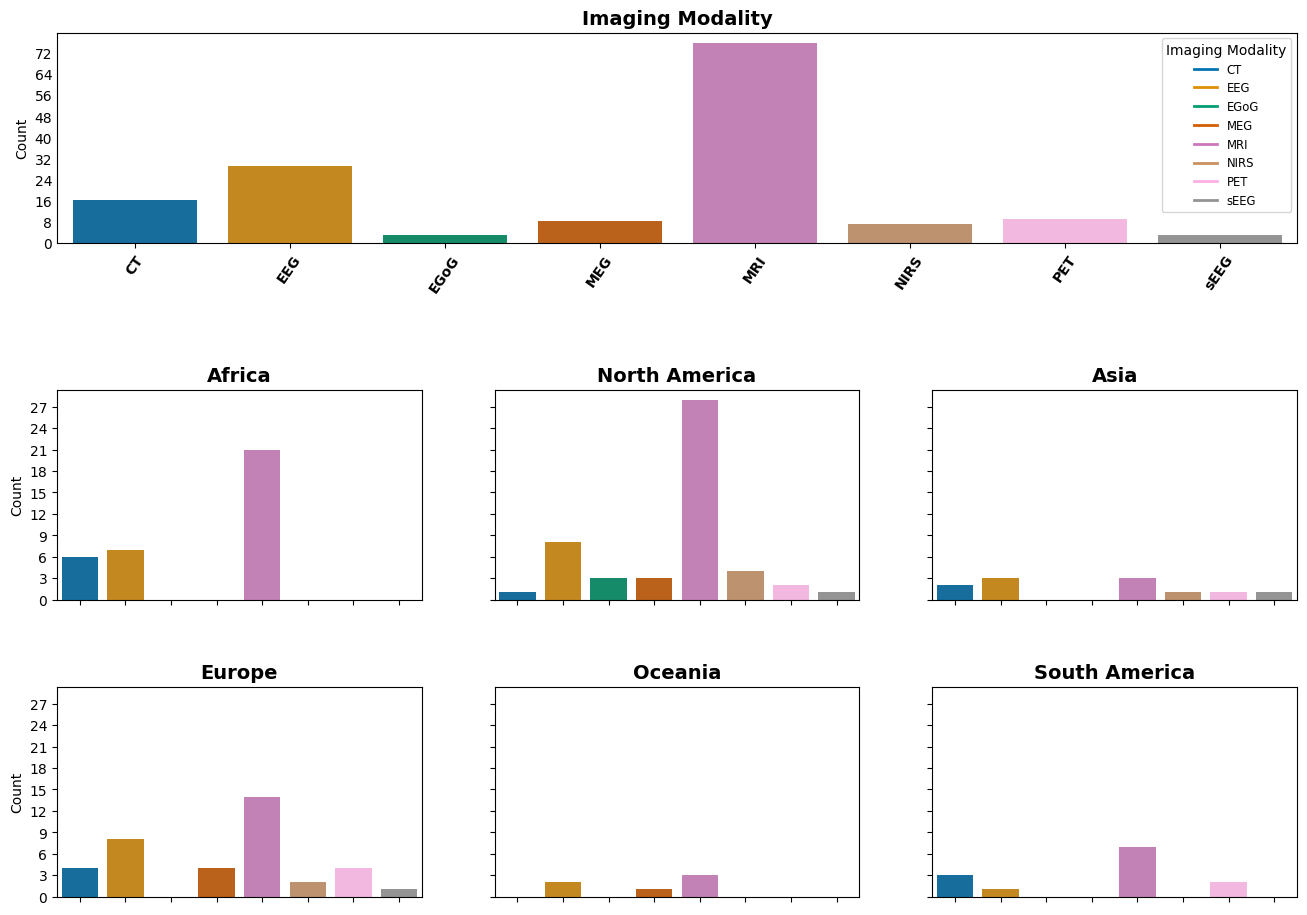

In [15]:
# Question 5: What types of neuroimaging data do you collect? (Check all that apply)
q5 = "What types of neuroimaging data do you collect? (Check all that apply)"
q5_survey = preprocess_question(survey, q5)

plot_categorical_by_continent(
    q5_survey,
    "What types of neuroimaging data do you collect? (Check all that apply)",
    "Imaging Modality",
    {"Behavioral", "Synesthesia."},
    top_plot_separation=0.7,
)

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


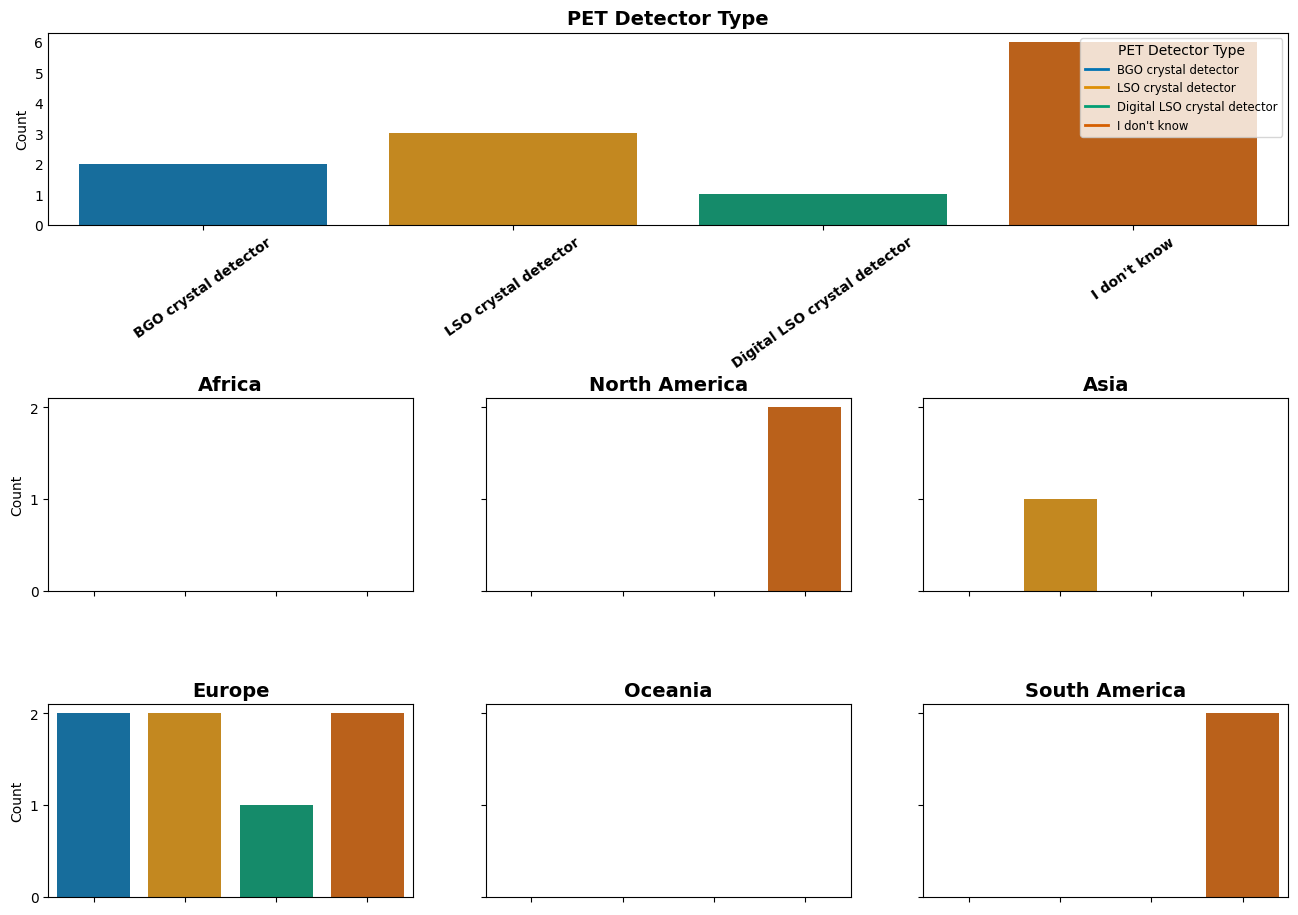

In [16]:
# Question 6: What type(s) of detectors do your PET machines have?
q6 = "What type(s) of detectors do your PET machines have?"
plot_categorical_by_continent(
    survey,
    q6,
    "PET Detector Type",
    x_label_rotation=35,
    all_categories=cleaned_q_name_option_mapping[q6]
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


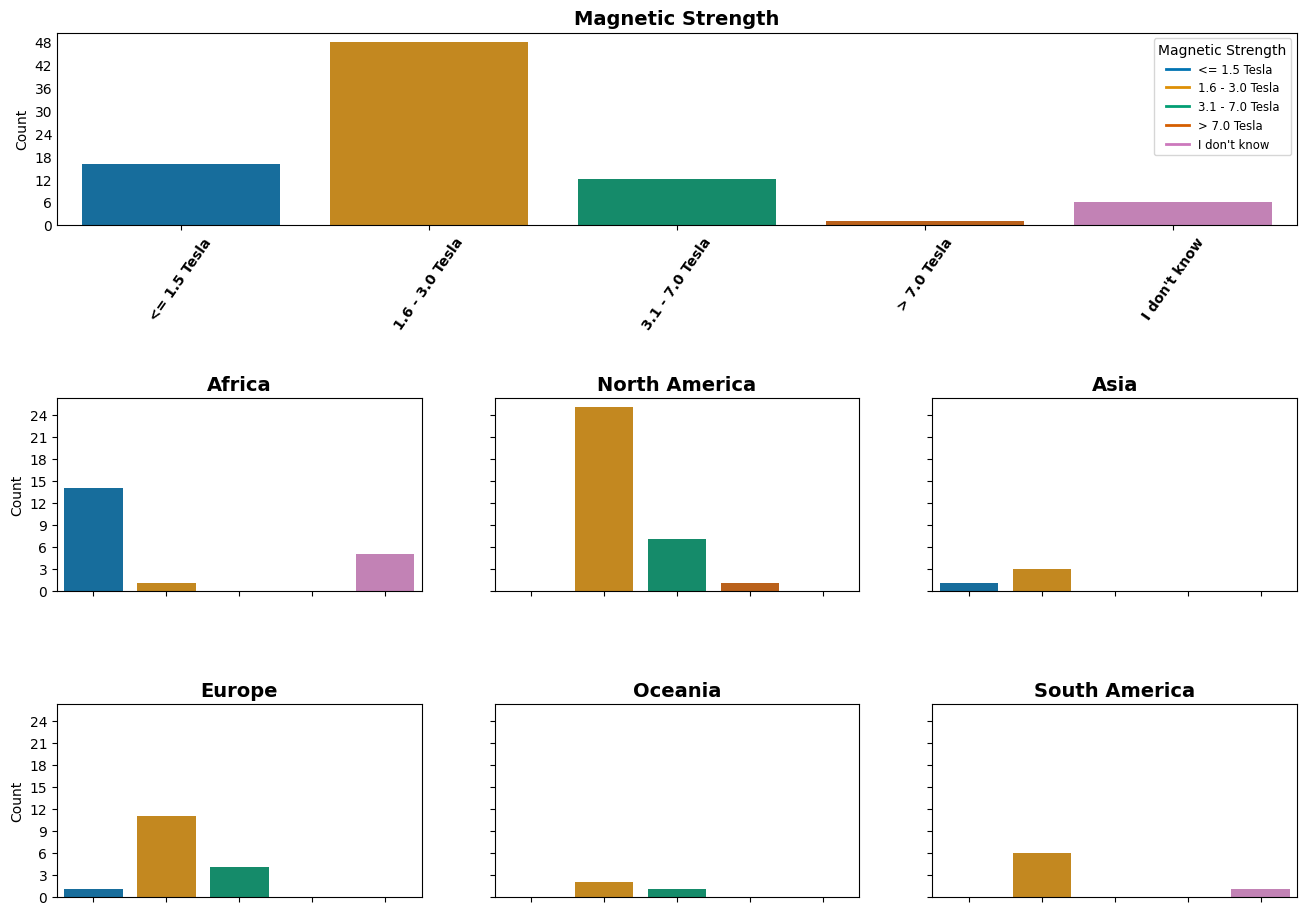

In [17]:
# Question 7: "What is the magnetic strength of the MRI machine(s)?"
q7 = "What is the magnetic strength of the MRI machine(s)?"
q7_options = cleaned_q_name_option_mapping[q7]
q7_replacements = {
    "1.5 - 3.0 Tesla": "1.6 - 3.0 Tesla",
    "less than or equal to 1.5 Tesla": "<= 1.5 Tesla",
    "greater than 7.0 Tesla": "> 7.0 Tesla",
}
q7_survey = preprocess_question(survey, q7, replacements=q7_replacements, multichoice=True)
plot_categorical_by_continent(
    q7_survey,
    "What is the magnetic strength of the MRI machine(s)?",
    "Magnetic Strength",
    all_categories=("<= 1.5 Tesla", "1.6 - 3.0 Tesla", "3.1 - 7.0 Tesla", "> 7.0 Tesla", "I don't know")
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


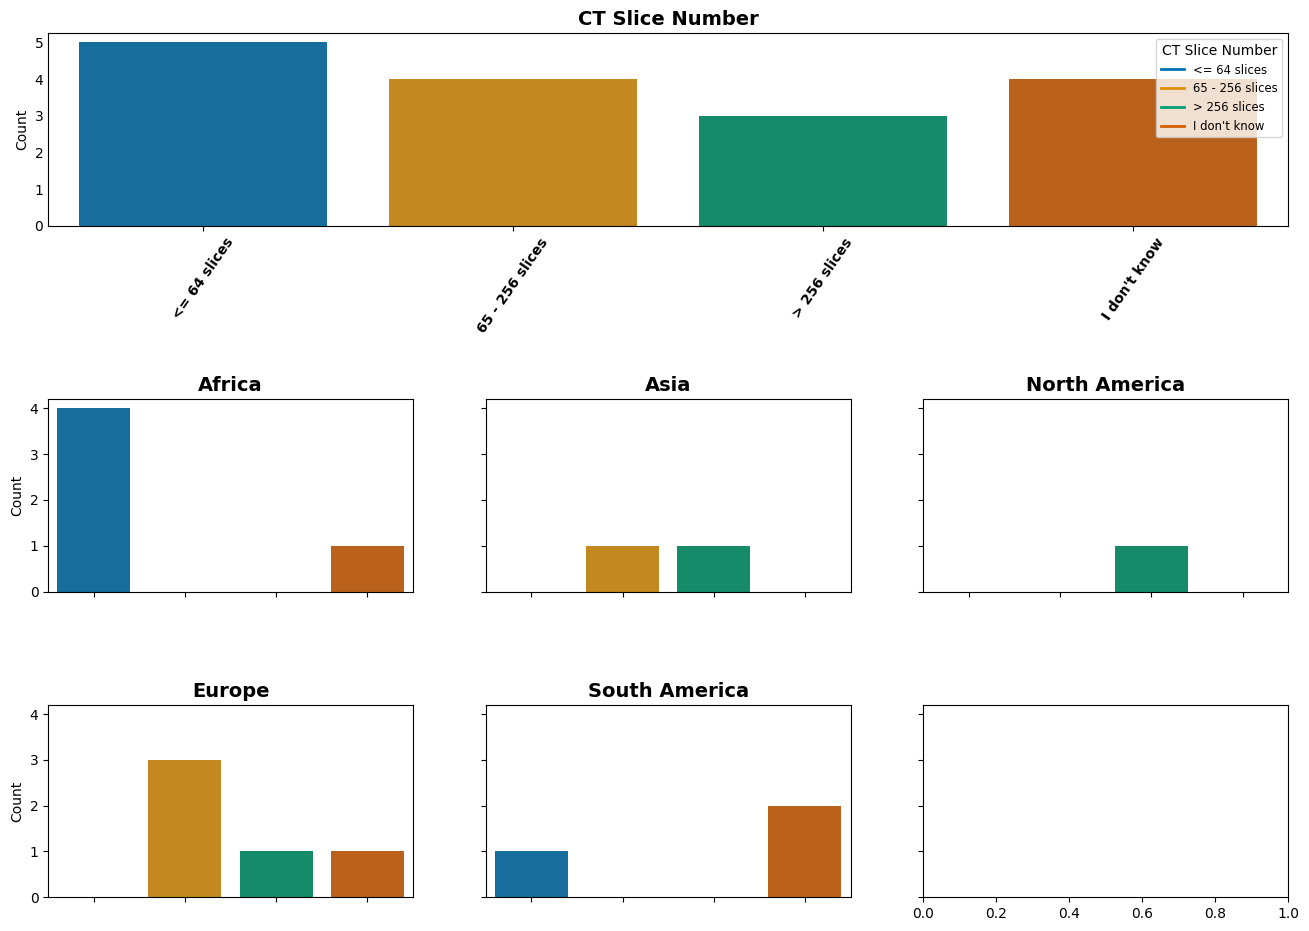

In [18]:
# Question 8: "How many slices do the CT machine(s) collect?"
q8 = "How many slices do the CT machine(s) collect?"
q8_replacements = {
    "less than 64 slices": "<= 64 slices",
    "greater than 256 slices": "> 256 slices",
    "< 64 slices": "<= 64 slices",
    "64slices": "<= 64 slices",
}
q8_survey = preprocess_question(survey, q8, replacements=q8_replacements, multichoice=True)
plot_categorical_by_continent(
    q8_survey,
    q8,
    "CT Slice Number",
    all_categories=("<= 64 slices", "65 - 256 slices", "> 256 slices", "I don't know")
)

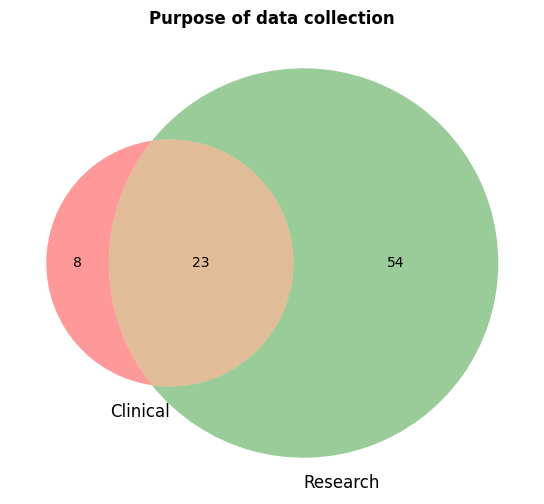

In [19]:
# Question 9: "What purpose(s) is the data being collected for?"
q9 = "What purpose(s) is the data being collected for?"

# Define sets for the Venn diagram
set_labels = ['Clinical', 'Research']
set_dict = {label: set() for label in set_labels}

# Populate sets based on categories
for index, category in survey.reset_index().iterrows():
    if pd.isna(category[q9]):
        continue
    categories = category[q9].split(',')
    if 'Clinical' in categories and 'Research' in categories:
        set_dict['Clinical'].add(index)
        set_dict['Research'].add(index)
    elif 'Clinical' in categories:
        set_dict['Clinical'].add(index)
    elif 'Research' in categories:
        set_dict['Research'].add(index)

# Plot Venn Diagram
plt.figure(figsize=(8, 6))
venn = venn2([set_dict['Clinical'], set_dict['Research']], 
             set_labels)
plt.title('Purpose of data collection', fontweight="bold")
plt.savefig('purpose.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


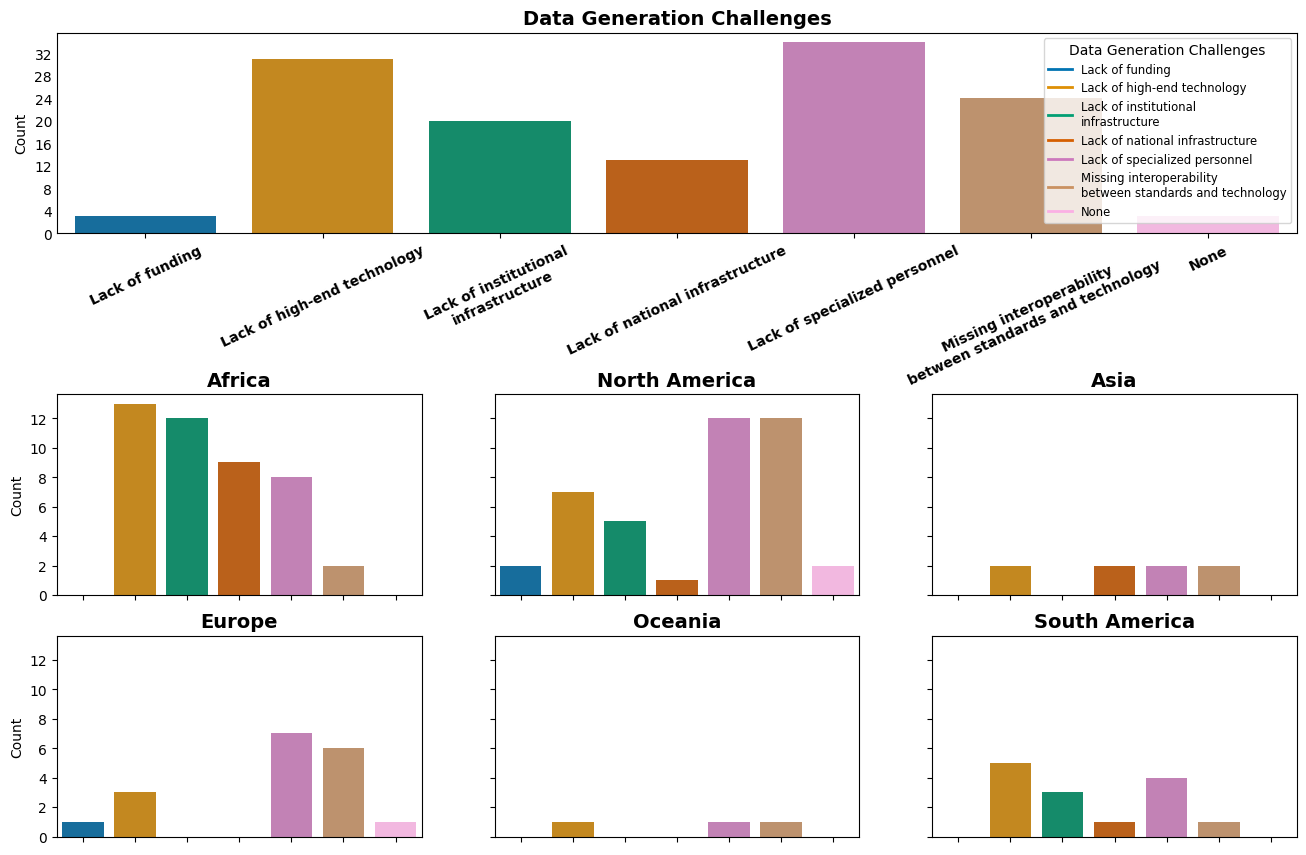

In [21]:
# question 10: What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)
q10 = "What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)"

q10_replacements = {
        "Funds": "Lack of funding",
        "not enough funding": "Lack of funding",
        " time": "Lack of funding",
        "Lack of individuals with synesthesia.": "None",
        "Lack of connection between neurologist": 'Lack of specialized personnel (people that generate protocols)',
        " radiologist and neuroscientist ": 'Lack of specialized personnel (people that generate protocols)',
}

q10_survey = preprocess_question(survey, q10, q10_replacements, multichoice=True)

plot_categorical_by_continent(
    q10_survey,
    q10,
    "Data Generation Challenges",
    exclude_categories={"lack of funding"},
    top_plot_separation=0.80, bottom_plot_squeeze=0.10, x_label_rotation=25
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


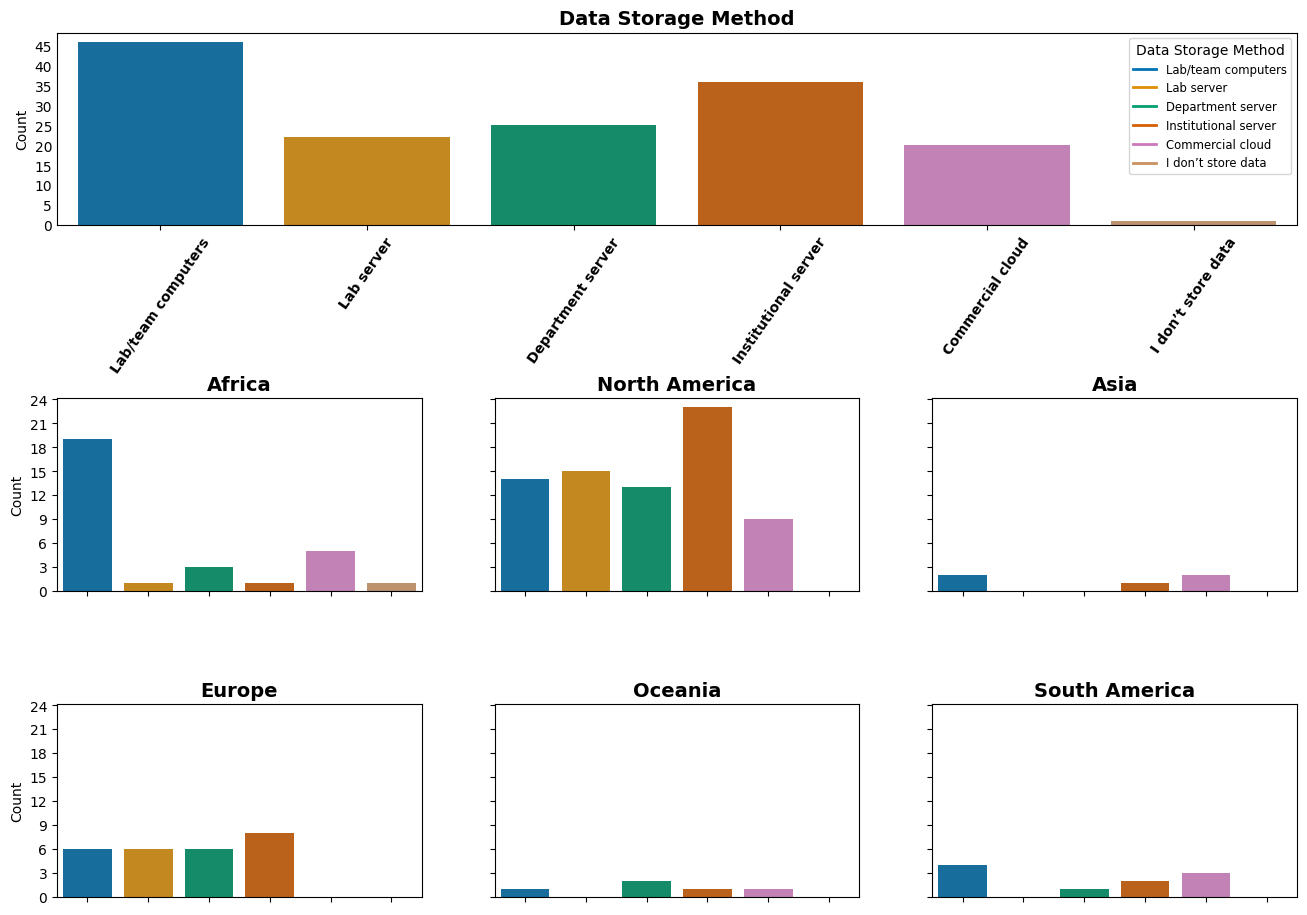

In [22]:
# question 11: How do you typically store your data? (Check all that apply)
q11 = "How do you typically store your data? (Check all that apply)"
q11_replacements = {
    "My own computer ": "Lab/team computers",
    "A disposable disc ": "Lab/team computers",
    "The use of compact disc ": "Lab/team computers",
    "CD ROM ": "Lab/team computers",
    "OpenNeuro": "Commercial cloud",
    "Openneuro": "Commercial cloud",
    "External storage drive": "Lab/team computers",
}
q11_survey = preprocess_question(survey, q11, q11_replacements, multichoice=True)
q11_survey[q11].unique()

plot_categorical_by_continent(
    q11_survey,
    q11,
    "Data Storage Method",
    all_categories=cleaned_q_name_option_mapping[q11],
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


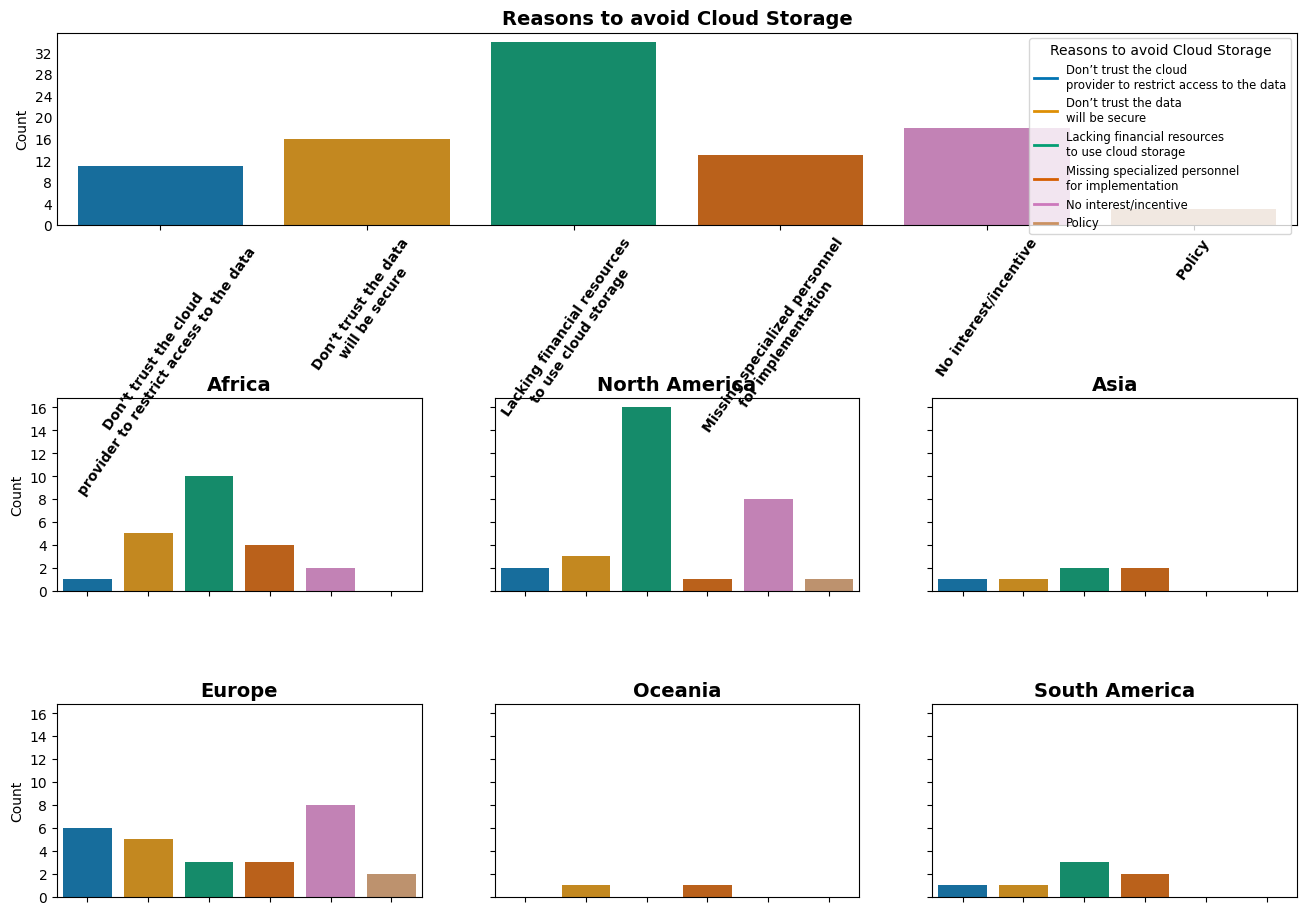

In [23]:
# Question 12: If you do not use cloud storage, what are the main barrier(s)?
q12 = "If you do not use cloud storage, what are the main barrier(s)?"
q12_replacements = {
    "Cost (for commercial cloud; I use institutional HPC)": "Lacking financial resources to use cloud storage",
    "Have enough local space.  Not sure institutional policies on cloud storage.": 'No interest/incentive',
    "not allowed": "Policy",
    "ethics requirements": "Policy",
    "Recurring costs exceed buying a server": "Lacking financial resources to use cloud storage",
    'PI is against it': "Policy",
    ' for the reasons I checked': "Other",
}
q12_survey = preprocess_question(survey, q12, q12_replacements, multichoice=True)

plot_categorical_by_continent(
    q12_survey,
    q12,
    "Reasons to avoid Cloud Storage",
    exclude_categories={"Other"},
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


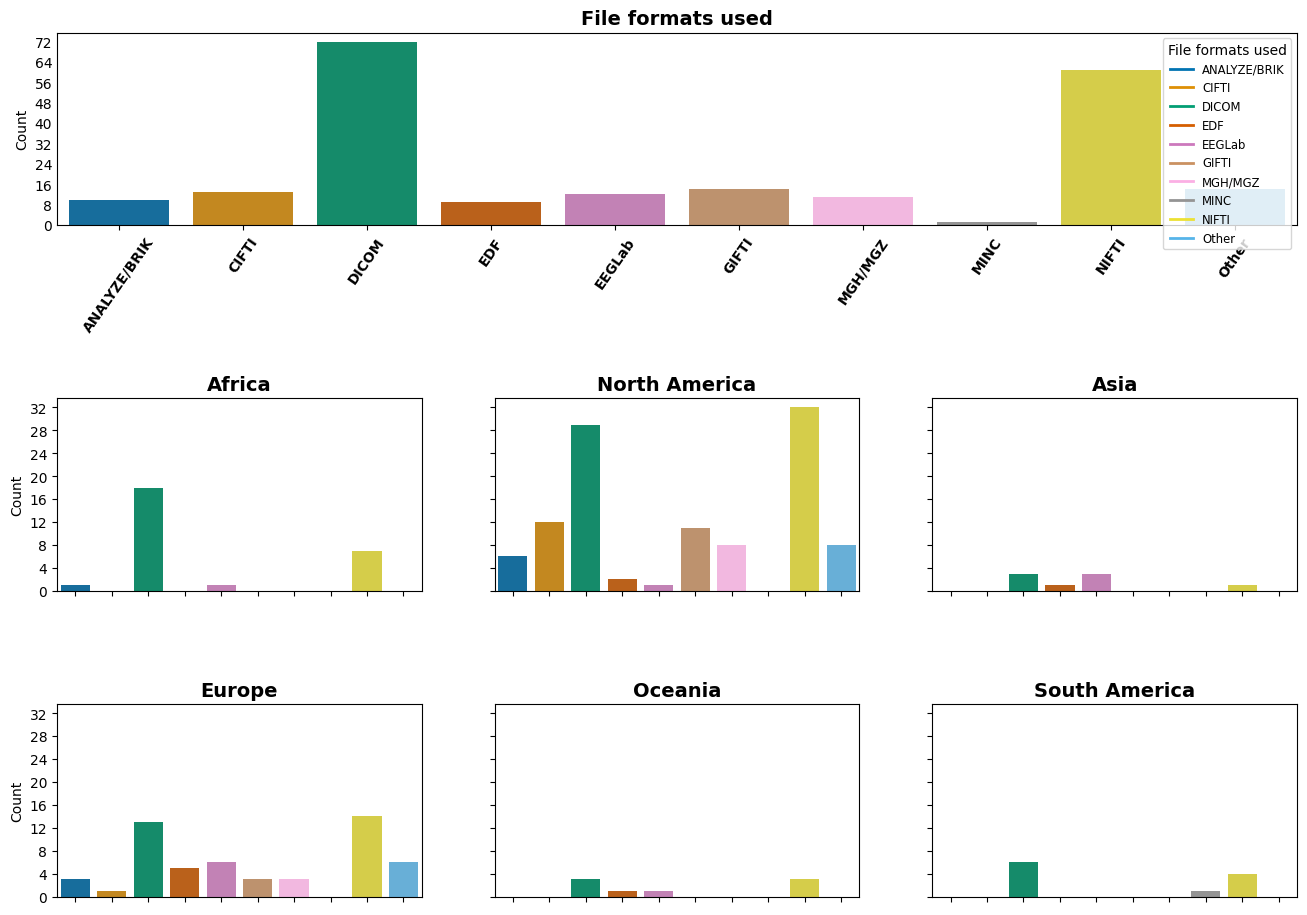

In [24]:
# Question 13: What file formats do you use? (Check all that apply)
q13 = "What file formats do you use? (Check all that apply)"
q13_replacements = {
    "BIDS": "NIFTI (Neuroimaging Informatics Technology Initiative)",
    "netstation MFF, Neuromag FIF": "Other",
    ".nirs": "Other",
    " .snirf": "Other",
    ".ds meg data ": "Other",
    "FIF": "Other",
    " CTF (DS)": "Other",
    "hdf5": "Other",
    "a variety of native eeg format": "Other",
    "Fif": "Other",
    " hdf5": "Other",
    " brainvision .eeg/.vhdr": "Other",
    "EEG datastore of vendor then exported to EEGlab": "Other",
    " mat": "Other",
}
q13_survey = preprocess_question(survey, q13, q13_replacements, multichoice=True)
q13_survey[q13].unique()

plot_categorical_by_continent(
    q13_survey,
    q13,
    "File formats used",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


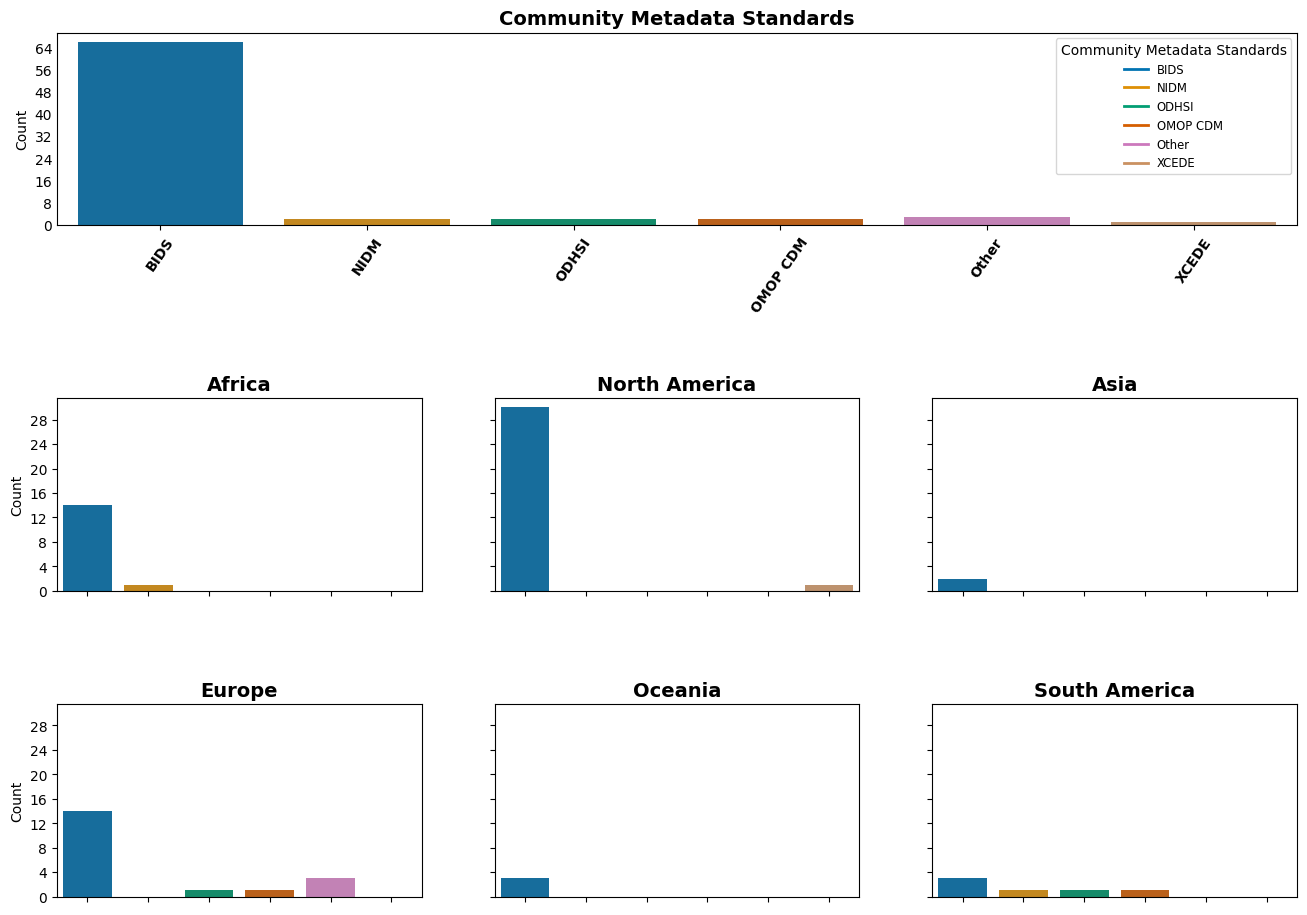

In [25]:
# Question 14: Which of the following community (meta)data models do you use? (Check all that apply)
q14 = "Which of the following community (meta)data models do you use? (Check all that apply)"
q14_replacements = {
    "json sidecar files with NIFTI header data": "Other",
    "I dont like BIDS but that is what we use": "Other",
    " mostly avoid all of this terrible stuff when I can. ": "Other",
}
q14_survey = preprocess_question(survey, q14, q14_replacements, multichoice=True)
q14_survey[q14].unique()

plot_categorical_by_continent(
    q14_survey,
    q14,
    "Community Metadata Standards",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


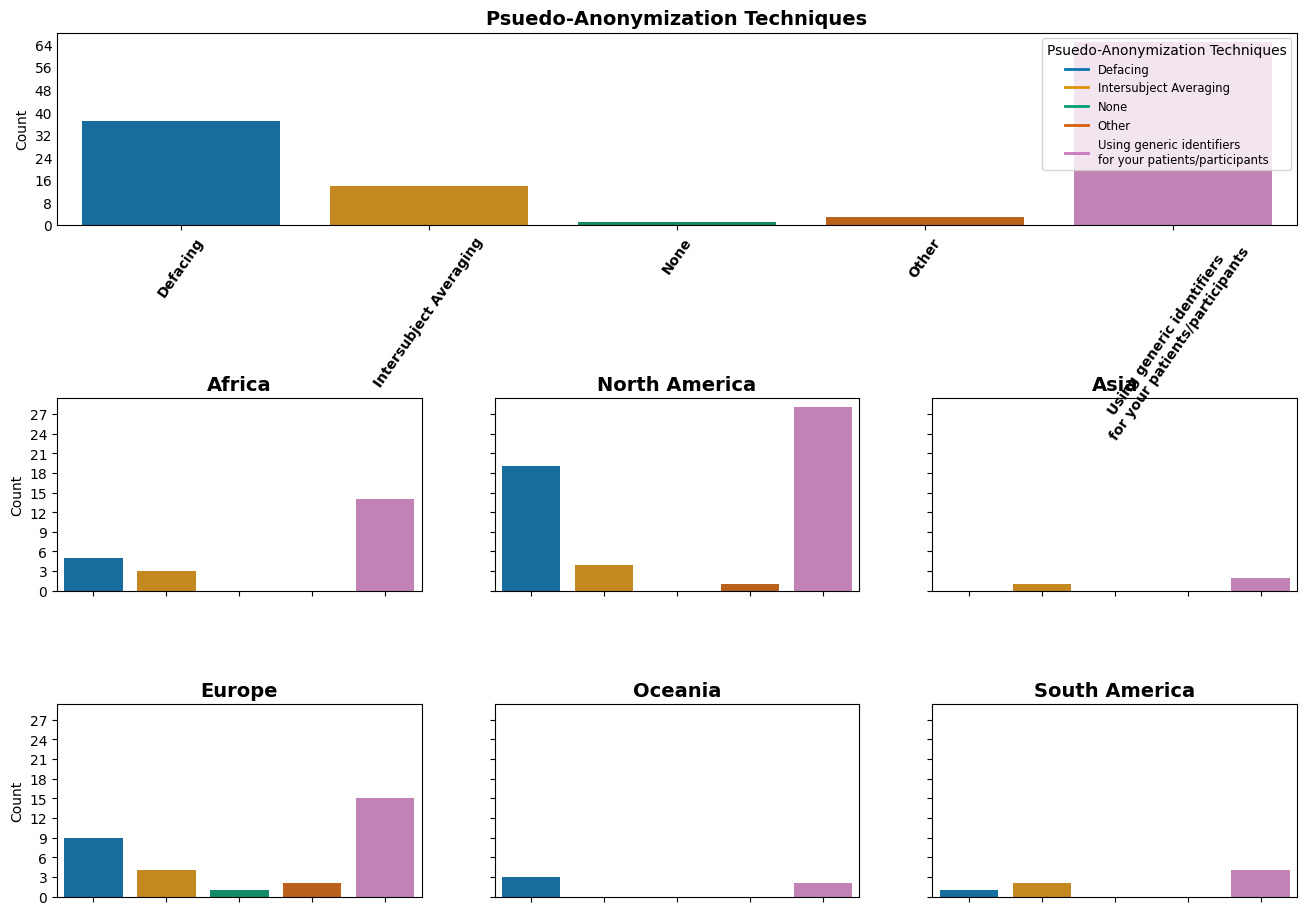

In [26]:
# Question 15: How do you deidentify your data? (Check all that apply)
q15 = "How do you deidentify your data? (Check all that apply)"
q15_replacements = {
    "Mysterious processes! :)": "Other",
    "use of unique identifiers like PIN": "Using generic identifiers for your patients/participants",
    "Removal of scan date/time and scanning site information from metadata": "Using generic identifiers for your patients/participants",
    "NLP for reports DISMED or similar": "Other",
    "Blurring of demographic data": "Other",
}

q15_survey = preprocess_question(survey, q15, q15_replacements, multichoice=True)

plot_categorical_by_continent(
    q15_survey,
    q15,
    "Psuedo-Anonymization Techniques",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


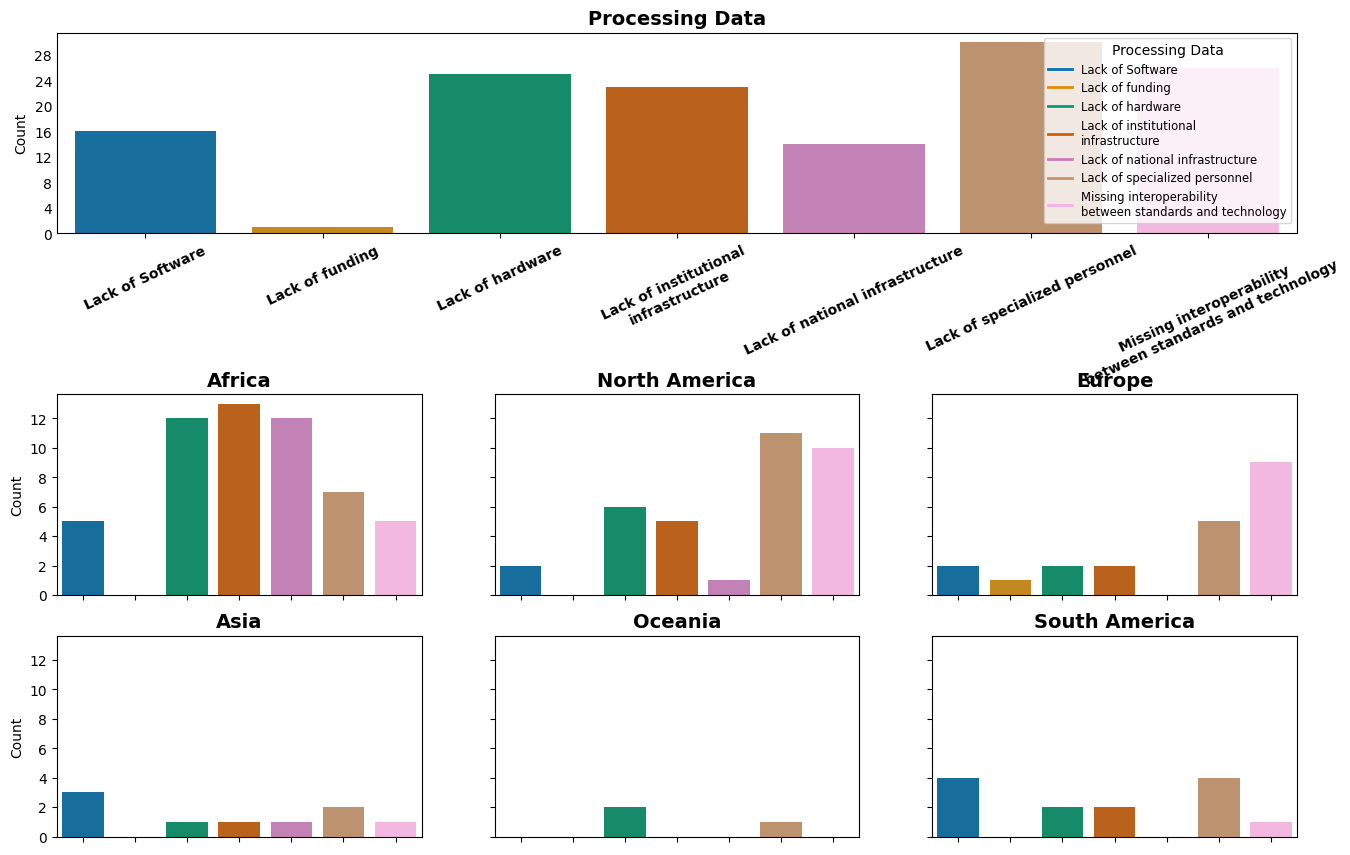

In [27]:
# Question 16: What are the barriers to processing your data? (Check all that apply)
q16 = "What are the barriers to processing your data? (Check all that apply)"
q16_replacements = {
    "Lack of standards ": "Missing interoperability between standards and technology (e.g.  software tools not working with your data)",
    "We've only found two participants worldwide. No operable standards.": "Missing interoperability between standards and technology (e.g.  software tools not working with your data)",
    "lack of funding": "Lack of funding",
    "GPU when using AI based tools": "Other",
    " eg generative models": "Lack of hardware(computers/scanners/lack of storage)",
    "Compute processing time": "Lack of hardware(computers/scanners/lack of storage)",
}
q16_survey = preprocess_question(survey, q16, q16_replacements, multichoice=True)

plot_categorical_by_continent(
    q16_survey,
    q16,
    "Processing Data",
    exclude_categories={"Other"},
    top_plot_separation=0.80, bottom_plot_squeeze=0.10, x_label_rotation=25
)

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


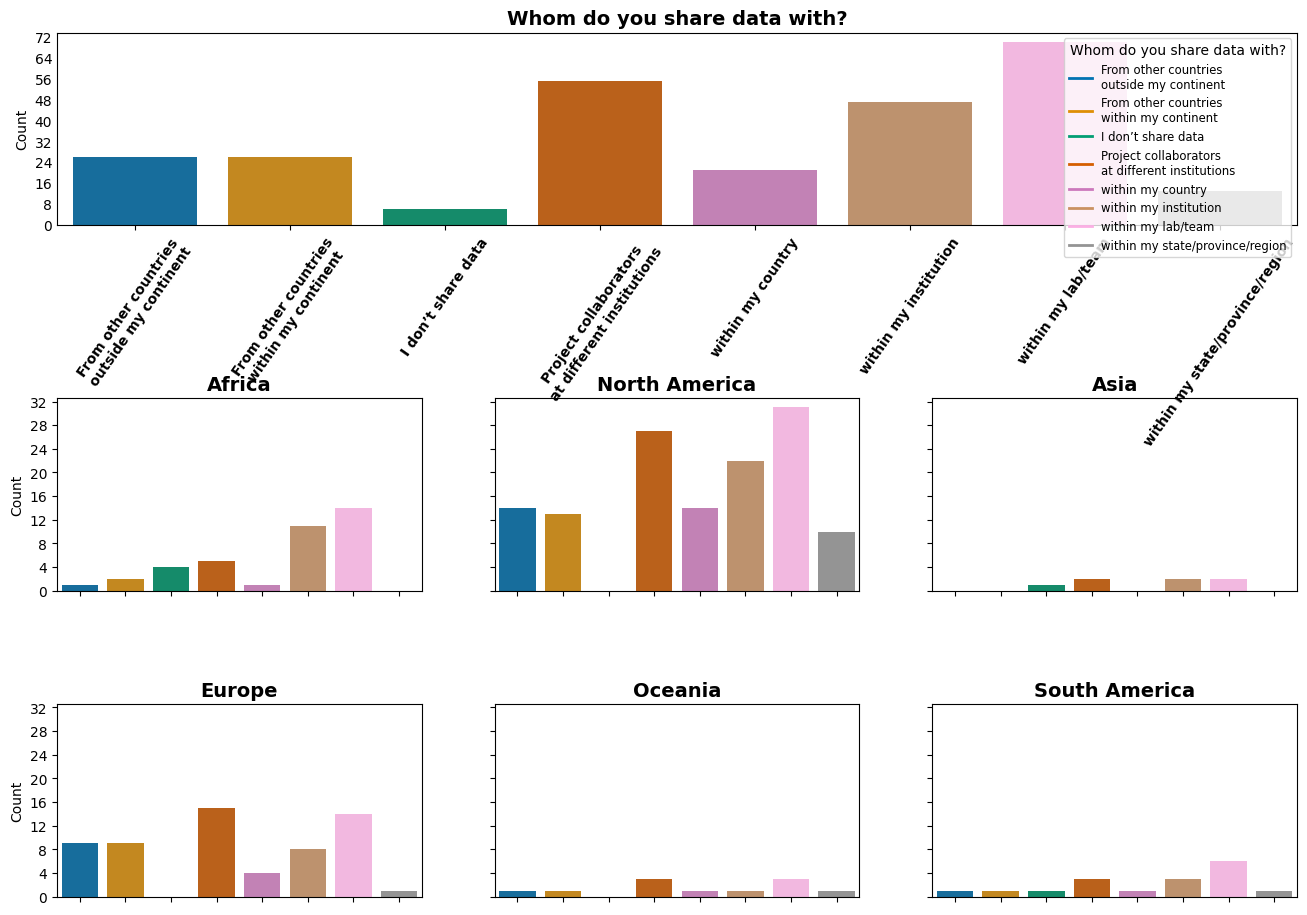

In [28]:
# Question 17: With whom do you typically share data? (Check all that apply)
q17 = "With whom do you typically share data? (Check all that apply)"
q17_replacements = {
    "I don't share data": "Other",
    "Depends on the project": "Other",
}

q17_survey = preprocess_question(survey, q17, q17_replacements, multichoice=True)
q17_survey[q17].unique()

plot_categorical_by_continent(
    q17_survey,
    q17,
    "Whom do you share data with?",
    exclude_categories={"Other"},
)

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


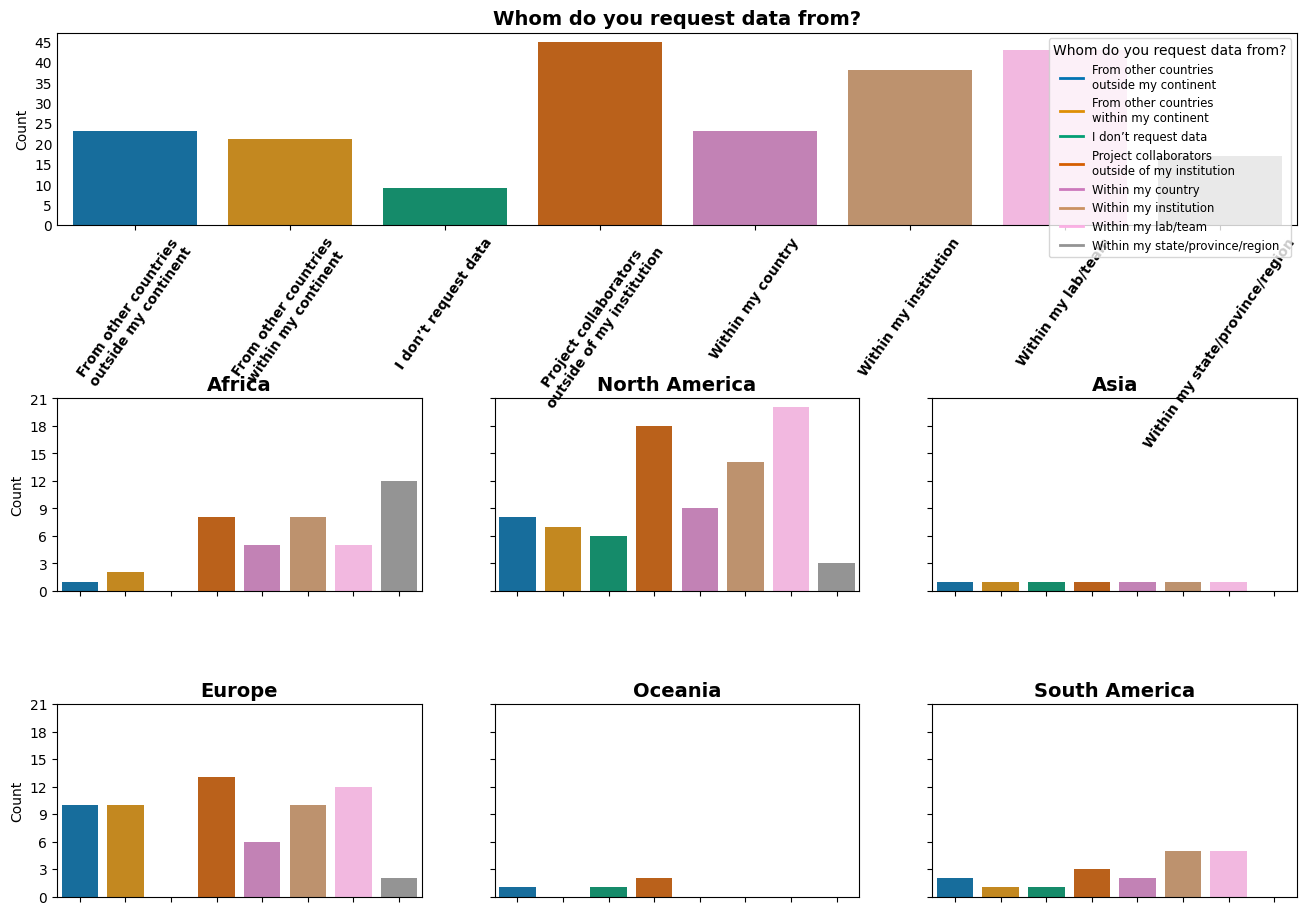

In [29]:
# Question 18: From whom do you typically request data? (Check all that apply)
q18 = "From whom do you typically request data? (Check all that apply)"

q18_survey = preprocess_question(survey, q18, multichoice=True)
q18_survey[q18].unique()

plot_categorical_by_continent(
    q18_survey,
    q18,
    "Whom do you request data from?",
    exclude_categories={"Other"},
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


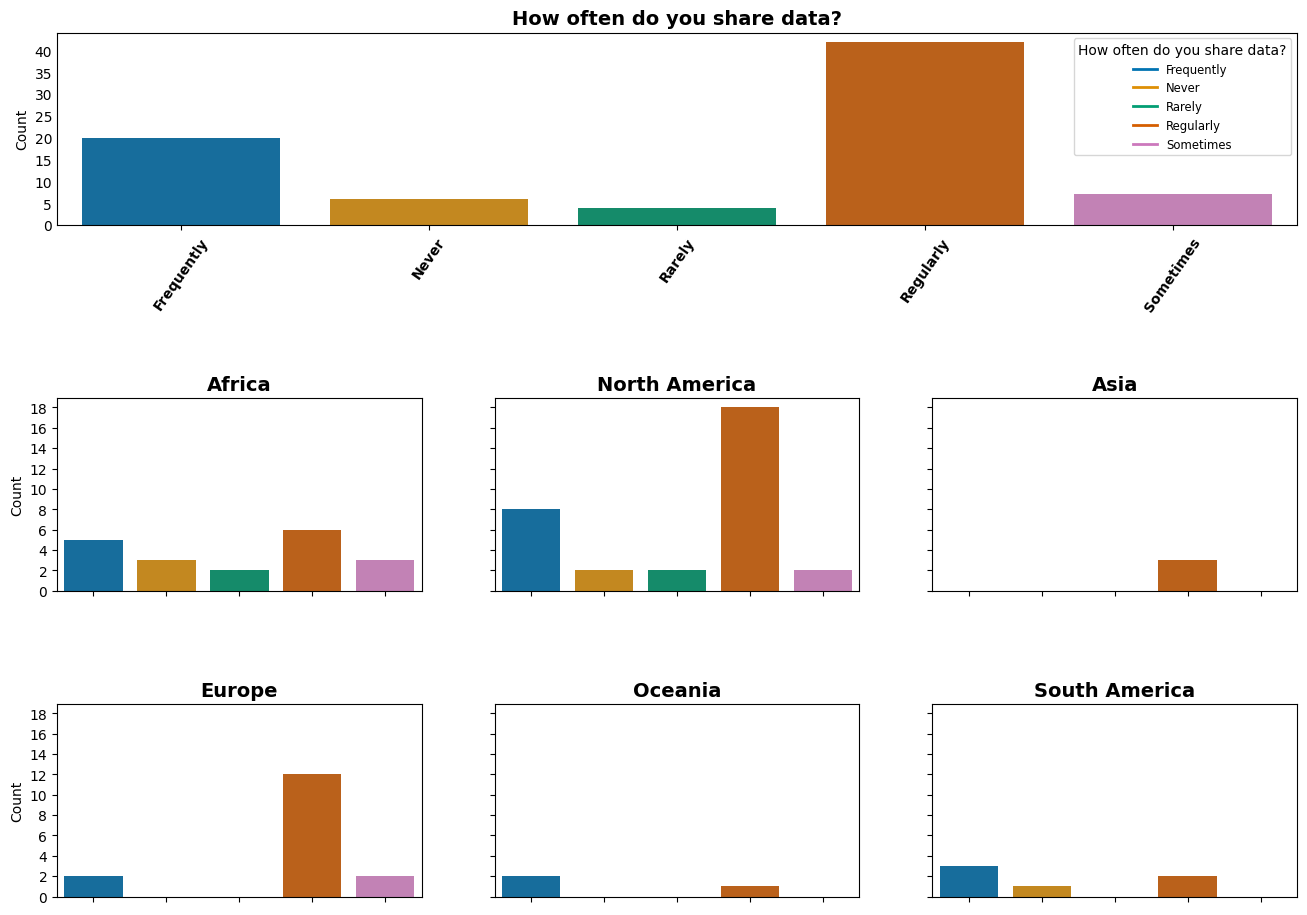

In [30]:
# Question 19: How frequently do you share data?
q19 = "How frequently do you share data?"
q19_replacements = {
    "Rarely (once a year or less)": "Regularly (once every 1-3 years)",
    "as needed in the clinic and project": "Regularly (once every 1-3 years)",
}

q19_survey = preprocess_question(survey, q19, q19_replacements, multichoice=False)

plot_categorical_by_continent(
    q19_survey,
    q19,
    "How often do you share data?",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


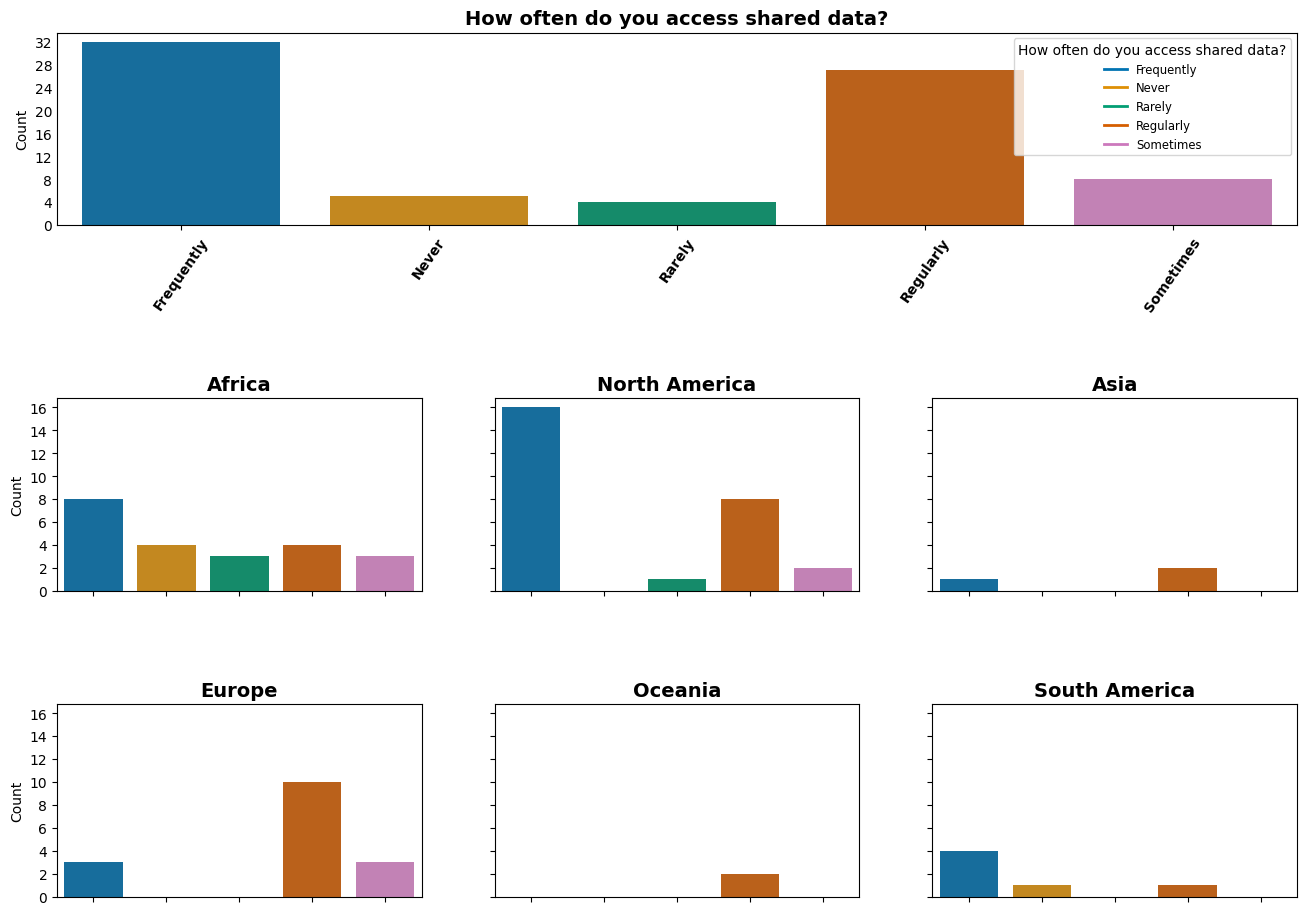

In [31]:
# Question 20: How frequently do you access shared data?
q20 = "How frequently do you access shared data?"
q20_replacements = {
    "Rarely (once a year or less)": "Regularly (once every 1-3 years)",
    "as needed in the clinic or project": "Regularly (once every 1-3 years)"
}

q20_survey = preprocess_question(survey, q20, q20_replacements, multichoice=False)

plot_categorical_by_continent(
    q20_survey,
    q20,
    "How often do you access shared data?",
)


/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


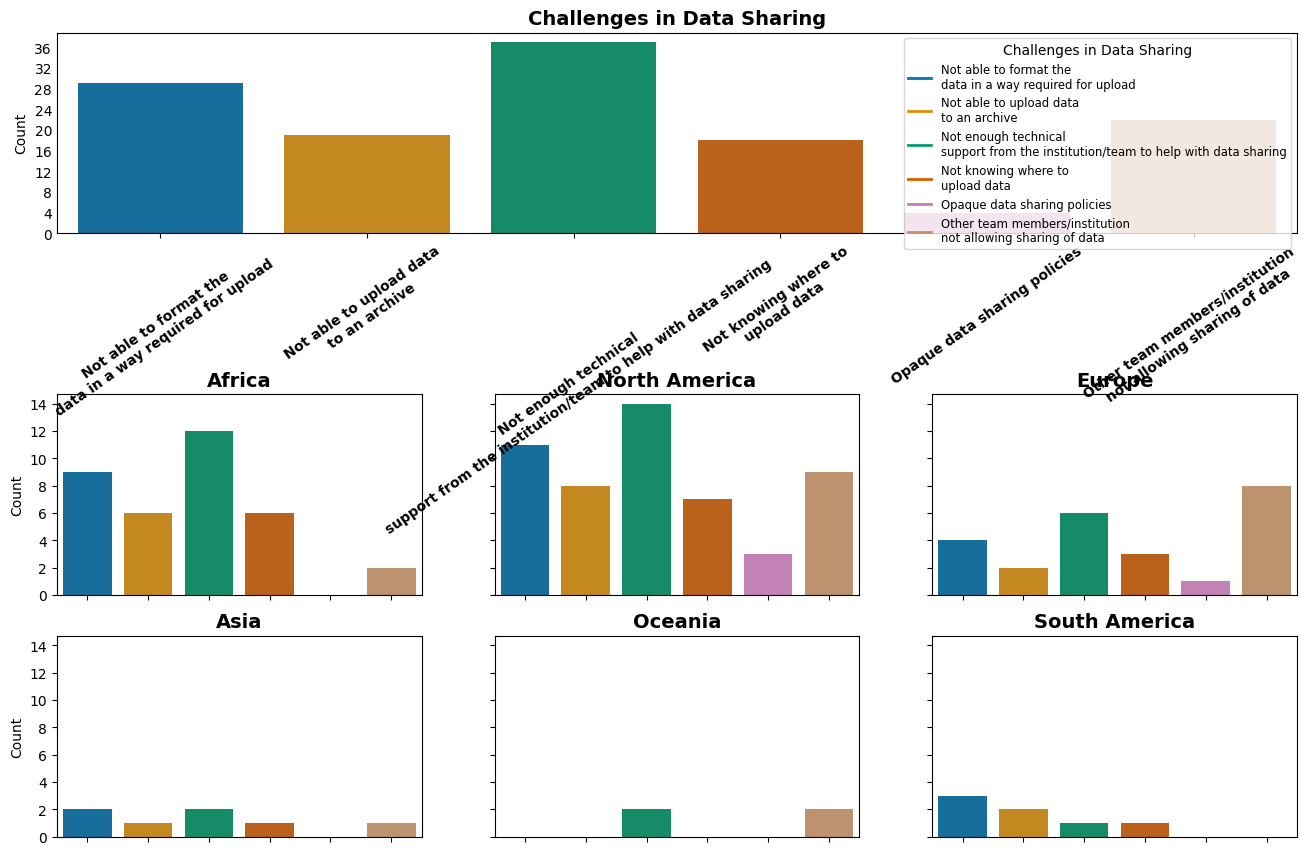

In [32]:
# Question 21: What are the top 3 challenges you have encountered while sharing data? (Can select fewer than 3)
q21 = "What are the top 3 challenges you have encountered while sharing data? (Can select fewer than 3)"

q21_replacements = {
    "Share it where? Synesthesia is like finding unicorns and as far as I know we are the only game in town.": "Other",
    "Complicated study designs and imaging acquisitions that are a bit of a headache with BIDS": "Not able to format the data in a way required for upload",
    "Different data standards and intersite harmonization ": "Not able to format the data in a way required for upload",
    "Legal barriers and delays": "Opaque data sharing policies",
    "DUA restricts sharing processed data.": "Other",
    "not having my own data": "Other",
    "Privacy regulations": "Opaque data sharing policies",
    "IRB/confidentiality concerns": "Opaque data sharing policies",
    "Cumbersome data sharing agreement processes ": "Opaque data sharing policies",
}

q21_survey = preprocess_question(survey, q21, q21_replacements, multichoice=True)
q21_survey[q21].unique()

plot_categorical_by_continent(
    q21_survey,
    q21,
    "Challenges in Data Sharing",
    exclude_categories={"Other"},
    top_plot_separation=0.80, bottom_plot_squeeze=0.10, x_label_rotation=35
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


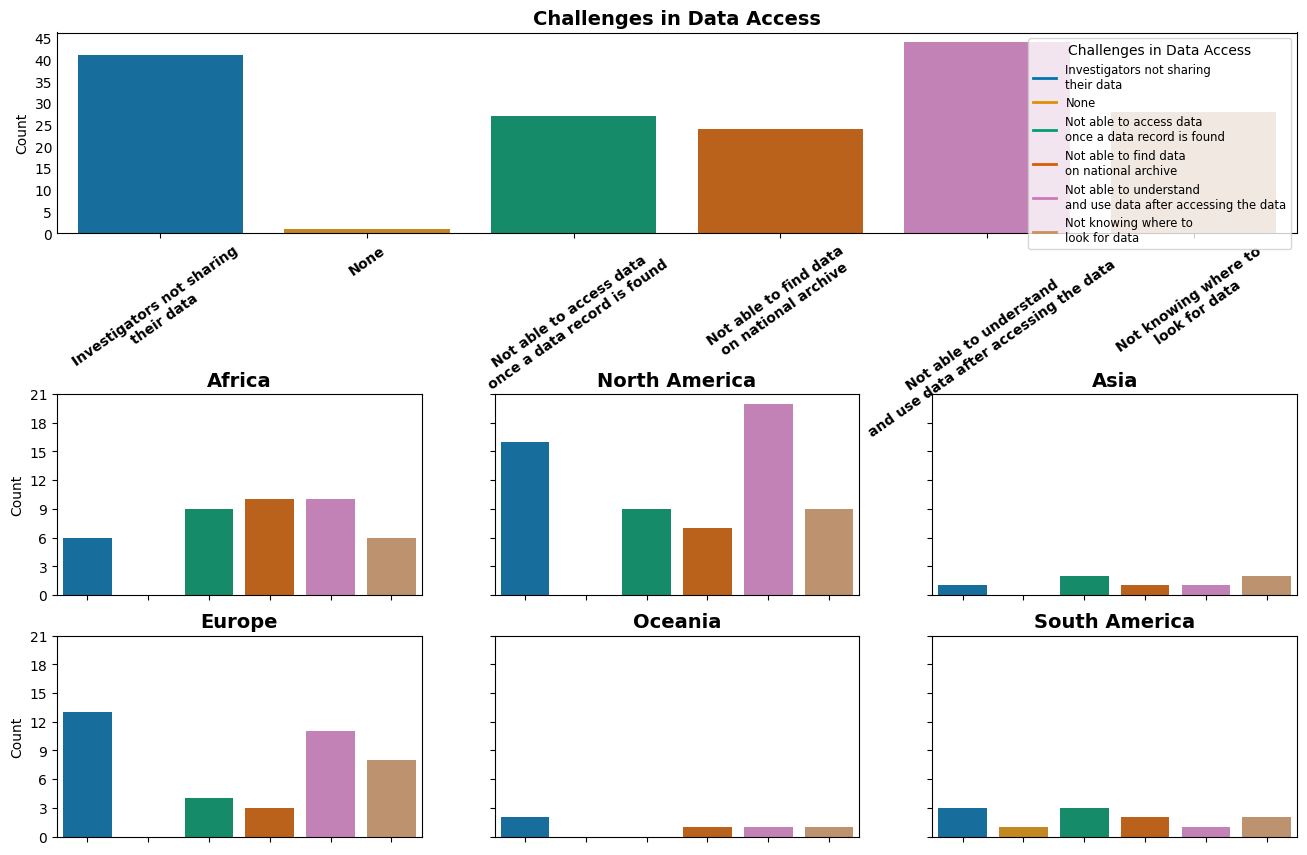

In [33]:
# Question 22: What are the top 3 challenges you have encountered to access data? (Can select fewer than 3)
q22 = "What are the top 3 challenges you have encountered to access data? (Can select fewer than 3)"
q22_replacements = {
    "I'm confident there are errors and omissions in the public COINs and NDA data that don't exist in house. Sloppy curation ": "Not able to understand and use data after accessing the data (not enough information)",
    "Not enough financial support to access data from other organizations": "Other",
    "It doesn't exist outside of our own research.": "Other",
    "havent tried accessing data of other institutions": "Other",
}

q22_survey = preprocess_question(survey, q22, q22_replacements, multichoice=True)
q22_survey[q22].unique()

plot_categorical_by_continent(
    q22_survey,
    q22,
    "Challenges in Data Access",
    exclude_categories={"Other"},
    top_plot_separation=0.80, bottom_plot_squeeze=0.10, x_label_rotation=35
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


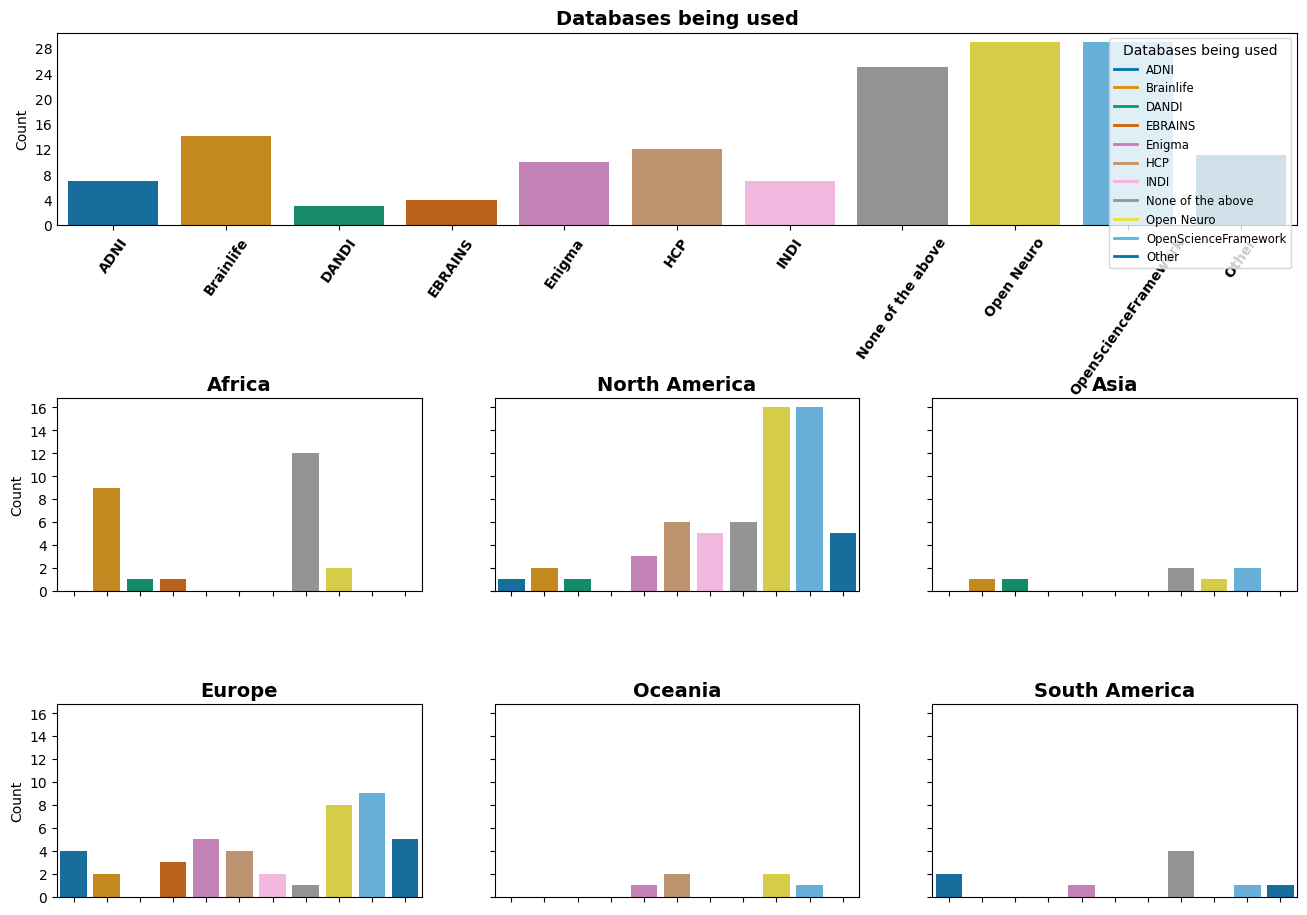

In [34]:
# Question 23: Have you used any of the following databases for sharing data? Select "Other" for an institutional database. (check all that apply)
q23 = "Have you used any of the following databases for sharing data? Select \"Other\" for an institutional database. (check all that apply)"
q23_replacements = {
    "institutional repository (we are not allowed to share data publicly on servers residing outside of country)": "Other",
    "gin.g-node.org": "Other",
    "Coinstack": "Other",
    "NIMH Data Archive": "Other",
    "CONP": "Other",
    "OpenPain": "Other",
    "BrainLat": "Other",
    "NDA": "Other",
    "Zenodo": "Other",
    " institutional ": "Other",
    "RedLat project": "Other",
}
q23_survey = preprocess_question(survey, q23, q23_replacements, multichoice=True)
q23_survey[q23].unique()

plot_categorical_by_continent(
    q23_survey,
    q23,
    "Databases being used",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


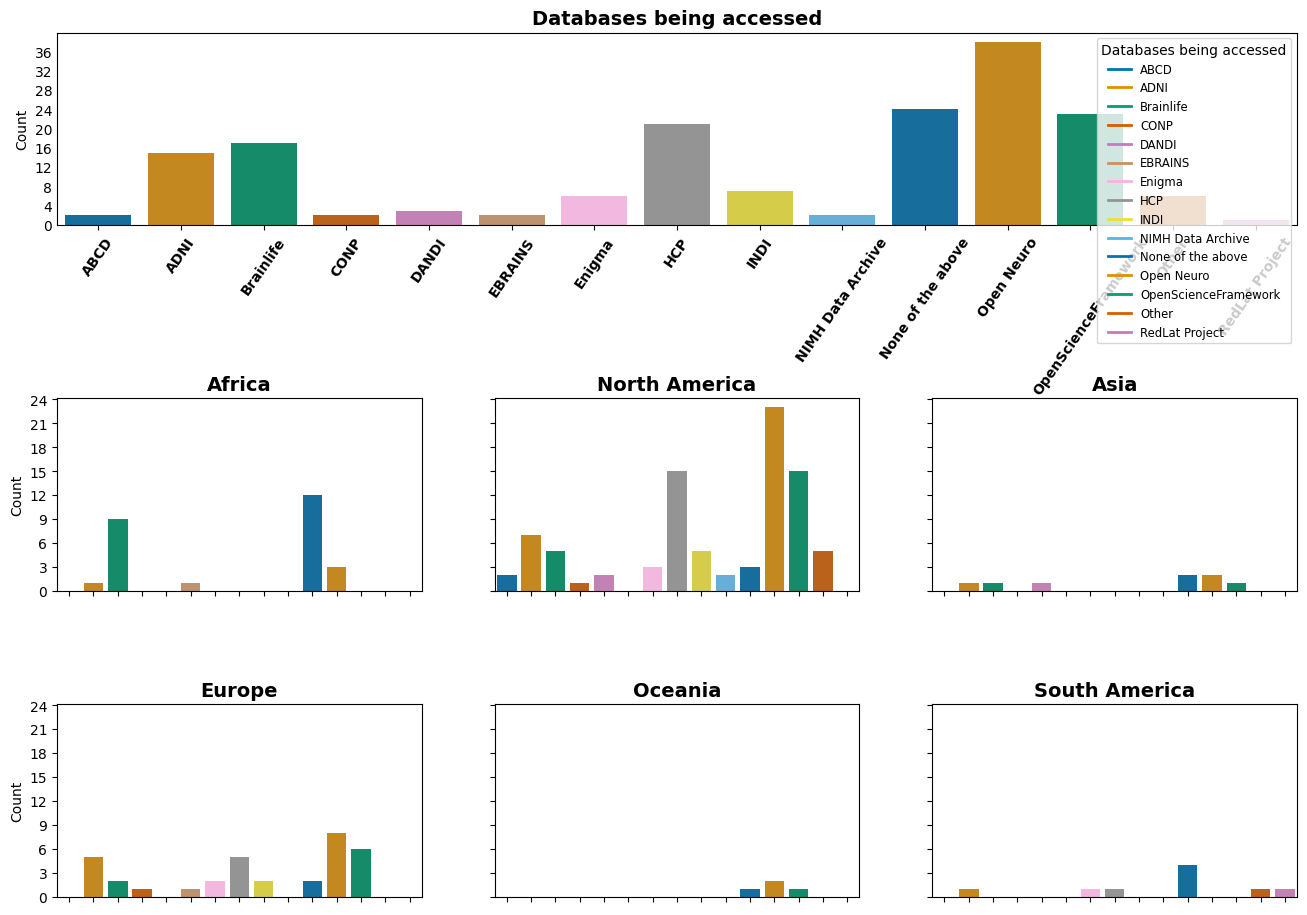

In [35]:
# Question 24: Have you used any of the following databases for reusing shared data? Select "Other" for an institutional database. (check all that apply)
q24 = "Have you used any of the following databases for reusing shared data? Select \"Other\" for an institutional database. (check all that apply)"
q24_replacements = {
    "UKB": "Other",
    " ABCD": "ABCD",
    "Institutional servers": "Other",
    "TACC": "Other",
    "Coinstack": "Other",
    "NDA": "Other",
    "RedLat project": "Other",
    "PPMI": "Other",
}
q24_survey = preprocess_question(survey, q24, q24_replacements, multichoice=True)
q24_survey[q24].unique()

plot_categorical_by_continent(
    q24_survey,
    q24,
    "Databases being accessed",
)

/tmp/ipykernel_1736249/224907459.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_survey.replace(replacements, inplace=True)
/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


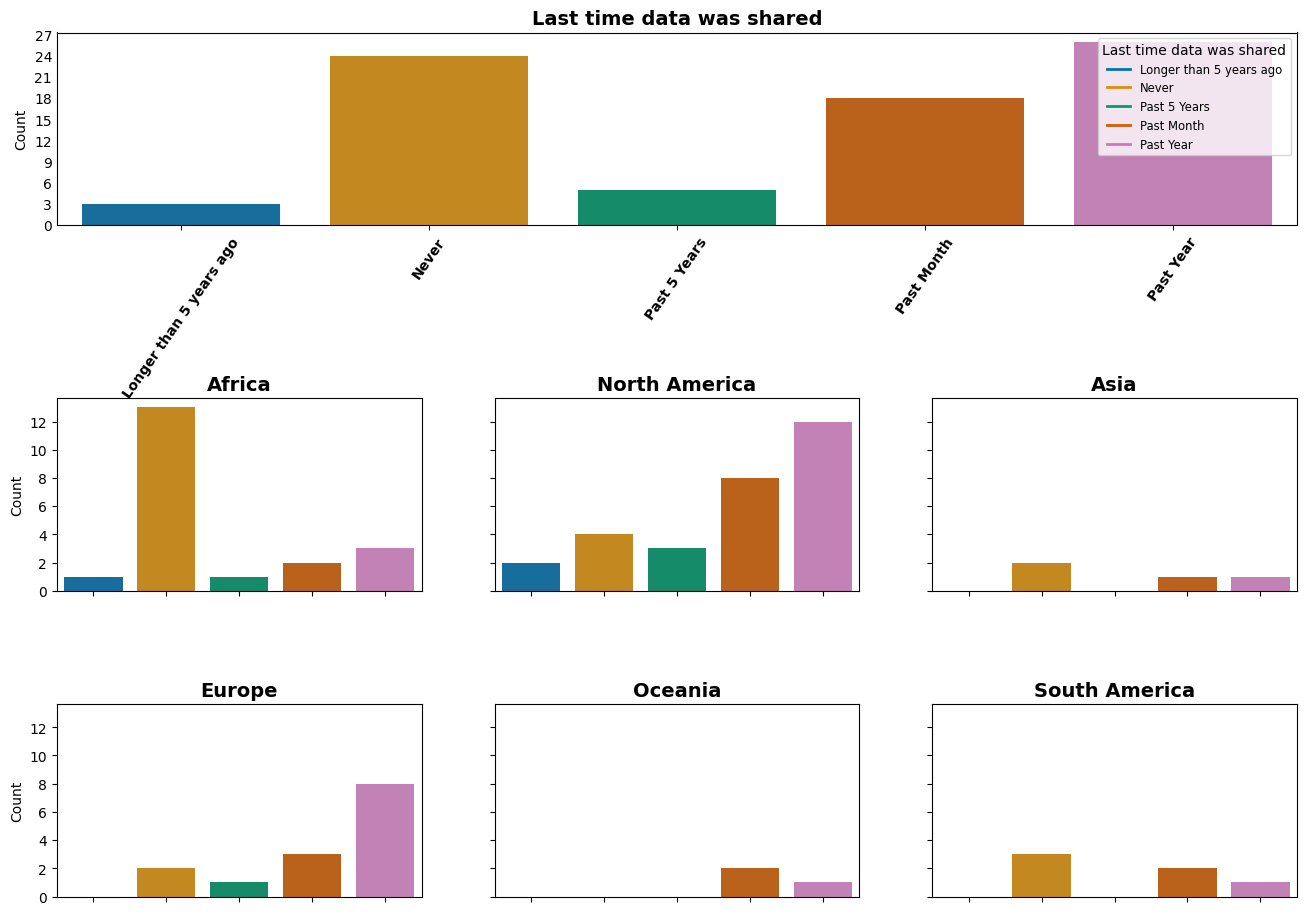

In [36]:
# Question 25: When did you last share data through a database?
q25 = "When did you last share data through a database?"
q25_replacements = {
    "PublicnEUro.eu": "Other",
    "We are about to - did not have ethics in place to do so before ": "Other"
}

q25_survey = preprocess_question(survey, q25, q25_replacements, multichoice=False)
q25_survey[q25].unique()

plot_categorical_by_continent(
    q25_survey,
    q25,
    "Last time data was shared",
    exclude_categories={"Other"}
)

/tmp/ipykernel_1736249/1878260254.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  overall_ax = plt.subplot2grid((rows + 1, 3), (0, 0), colspan=3)


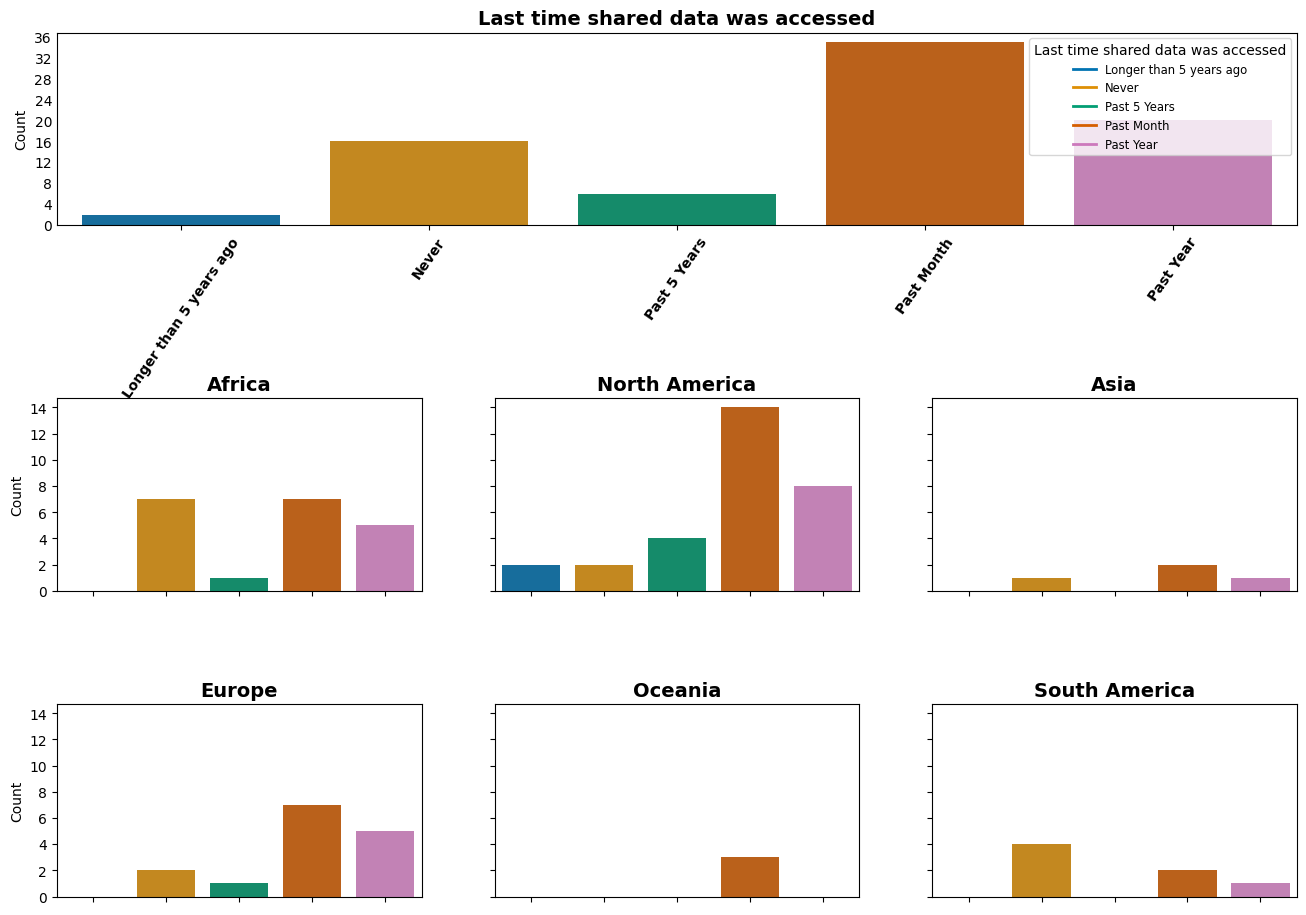

In [37]:
# Question 26: When did you last use data from a database?
q26 = "When did you last use data from a database?"

q26_survey = preprocess_question(survey, q26, multichoice=False)

plot_categorical_by_continent(
    q26_survey,
    q26,
    "Last time shared data was accessed",
)
